In [13]:
                                                             # ICM-20948 IMUSU 3D MODELLEME #

import pygame
import serial
import json
import threading
import time
from pygame.locals import *
from OpenGL.GL import *
from OpenGL.GLU import *
import math

class IMU3DVisualizer:
    def __init__(self, serial_port='COM3', baud_rate=115200):
        # Serial port ayarları
        self.serial_port = serial_port
        self.baud_rate = baud_rate
        self.ser = None
        
        # IMU verileri
        self.yaw = 0.0
        self.pitch = 0.0
        self.roll = 0.0
        
        # Threading için
        self.running = True
        self.data_lock = threading.Lock()
        
        # Pygame ve OpenGL başlatma
        pygame.init()
        self.display = (800, 600)
        pygame.display.set_mode(self.display, DOUBLEBUF | OPENGL)
        pygame.display.set_caption('ICM-20948 IMU 3D Görselleştirme')
        
        # OpenGL ayarları
        glEnable(GL_DEPTH_TEST)
        glMatrixMode(GL_PROJECTION)
        gluPerspective(45, (self.display[0]/self.display[1]), 0.1, 50.0)
        glMatrixMode(GL_MODELVIEW)
        glTranslatef(0.0, 0.0, -5)
        
        # Renk ayarları
        glEnable(GL_LIGHTING)
        glEnable(GL_LIGHT0)
        glLightfv(GL_LIGHT0, GL_POSITION, [1, 1, 1, 0])
        glLightfv(GL_LIGHT0, GL_DIFFUSE, [1, 1, 1, 1])
        glEnable(GL_COLOR_MATERIAL)
        glColorMaterial(GL_FRONT_AND_BACK, GL_AMBIENT_AND_DIFFUSE)
        
    def connect_serial(self):
        """Serial porta bağlanma"""
        try:
            self.ser = serial.Serial(self.serial_port, self.baud_rate, timeout=1)
            print(f"Serial porta bağlandı: {self.serial_port}")
            return True
        except Exception as e:
            print(f"Serial port hatası: {e}")
            print("Lütfen port adını kontrol edin. Örnek portlar:")
            print("Windows: COM3, COM4, COM5...")
            print("Linux/Mac: /dev/ttyUSB0, /dev/ttyACM0...")
            return False
    
    def read_serial_data(self):
        """Serial porttan veri okuma (thread içinde çalışır)"""
        while self.running and self.ser:
            try:
                if self.ser.in_waiting:
                    line = self.ser.readline().decode('utf-8').strip()
                    if line:
                        # JSON formatındaki veriyi parse et
                        data = json.loads(line)
                        
                        with self.data_lock:
                            self.yaw = data.get('yaw', 0)
                            self.pitch = data.get('pitch', 0)
                            self.roll = data.get('roll', 0)
                            
            except json.JSONDecodeError:
                # JSON decode hatası, geç
                pass
            except Exception as e:
                print(f"Veri okuma hatası: {e}")
                
            time.sleep(0.01)  # CPU kullanımını azalt
    
    def draw_cube(self):
        """Renkli küp çizme"""
        # Küp köşeleri
        vertices = [
            [1, 1, -1], [1, -1, -1], [-1, -1, -1], [-1, 1, -1],  # Arka yüz
            [1, 1, 1], [1, -1, 1], [-1, -1, 1], [-1, 1, 1]       # Ön yüz
        ]
        
        # Küp yüzleri ve renkleri
        faces = [
            ([0, 1, 2, 3], [1, 0, 0]),      # Arka - Kırmızı
            ([4, 7, 6, 5], [0, 1, 0]),      # Ön - Yeşil
            ([0, 4, 5, 1], [0, 0, 1]),      # Sağ - Mavi
            ([2, 6, 7, 3], [1, 1, 0]),      # Sol - Sarı
            ([0, 3, 7, 4], [1, 0, 1]),      # Üst - Magenta
            ([1, 5, 6, 2], [0, 1, 1])       # Alt - Cyan
        ]
        
        glBegin(GL_QUADS)
        for face, color in faces:
            glColor3fv(color)
            for vertex in face:
                glVertex3fv(vertices[vertex])
        glEnd()
        
        # Küp kenarları (siyah çizgiler)
        edges = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Arka yüz kenarları
            [4, 5], [5, 6], [6, 7], [7, 4],  # Ön yüz kenarları
            [0, 4], [1, 5], [2, 6], [3, 7]   # Bağlantı kenarları
        ]
        
        glColor3f(0, 0, 0)  # Siyah renk
        glLineWidth(2)
        glBegin(GL_LINES)
        for edge in edges:
            for vertex in edge:
                glVertex3fv(vertices[vertex])
        glEnd()
    
    def draw_axes(self):
        """Koordinat eksenleri çizme"""
        glLineWidth(3)
        glBegin(GL_LINES)
        
        # X ekseni - Kırmızı
        glColor3f(1, 0, 0)
        glVertex3f(0, 0, 0)
        glVertex3f(2, 0, 0)
        
        # Y ekseni - Yeşil
        glColor3f(0, 1, 0)
        glVertex3f(0, 0, 0)
        glVertex3f(0, 2, 0)
        
        # Z ekseni - Mavi
        glColor3f(0, 0, 1)
        glVertex3f(0, 0, 0)
        glVertex3f(0, 0, 2)
        
        glEnd()
    
    def apply_rotation(self):
        """IMU verilerine göre rotasyon uygulama"""
        with self.data_lock:
            yaw, pitch, roll = self.yaw, self.pitch, self.roll
        
        # Euler açılarını OpenGL rotasyonlarına dönüştür
        glRotatef(roll, 1, 0, 0)    # Roll (X ekseni etrafında)
        glRotatef(pitch, 0, 1, 0)   # Pitch (Y ekseni etrafında)
        glRotatef(yaw, 0, 0, 1)     # Yaw (Z ekseni etrafında)
    
    def draw_info_text(self):
        """Açı değerlerini ekranda gösterme (basit)"""
        with self.data_lock:
            yaw, pitch, roll = self.yaw, self.pitch, self.roll
        
        # Pygame yüzeyine metin yazdırma (OpenGL ile karışık kullanım)
        info_text = f"Yaw: {yaw:.1f}° | Pitch: {pitch:.1f}° | Roll: {roll:.1f}°"
        pygame.display.set_caption(f'ICM-20948 IMU 3D Görselleştirme - {info_text}')
    
    def run(self):
        """Ana döngü"""
        # Serial bağlantısı
        if not self.connect_serial():
            print("Serial port bağlantısı başarısız! Demo modda çalışıyor...")
            # Demo modu için sahte veri üret
            self.demo_mode = True
        else:
            self.demo_mode = False
            # Serial okuma thread'ini başlat
            serial_thread = threading.Thread(target=self.read_serial_data)
            serial_thread.daemon = True
            serial_thread.start()
        
        clock = pygame.time.Clock()
        demo_time = 0
        
        try:
            while self.running:
                # Event handling
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        self.running = False
                    elif event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            self.running = False
                        elif event.key == pygame.K_r:
                            # Reset rotasyonu
                            with self.data_lock:
                                self.yaw = self.pitch = self.roll = 0
                
                # Demo modu için sahte veri üret
                if self.demo_mode:
                    demo_time += 0.05
                    with self.data_lock:
                        self.yaw = math.sin(demo_time) * 45
                        self.pitch = math.cos(demo_time * 0.7) * 30
                        self.roll = math.sin(demo_time * 1.3) * 20
                
                # Ekranı temizle
                glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
                
                # Matrix'i kaydet
                glPushMatrix()
                
                # Koordinat eksenleri çiz
                self.draw_axes()
                
                # IMU rotasyonunu uygula
                self.apply_rotation()
                
                # Küpü çiz
                self.draw_cube()
                
                # Matrix'i geri yükle
                glPopMatrix()
                
                # Bilgi metnini güncelle
                self.draw_info_text()
                
                # Ekranı güncelle
                pygame.display.flip()
                clock.tick(60)  # 60 FPS
                
        except KeyboardInterrupt:
            print("Program sonlandırılıyor...")
        finally:
            self.cleanup()
    
    def cleanup(self):
        """Temizlik işlemleri"""
        self.running = False
        if self.ser:
            self.ser.close()
        pygame.quit()

if __name__ == "__main__":
    print("ICM-20948 IMU 3D Görselleştirme")
    print("Kontroller:")
    print("- ESC veya pencereyi kapatma: Çıkış")
    print("- R tuşu: Rotasyonu sıfırla")
    port = input("Seri port giriniz (varsayılan: COM6): ").strip()
    print("=" * 60)

    visualizer = IMU3DVisualizer(serial_port=port, baud_rate=115200)
    visualizer.run()

ICM-20948 IMU 3D Görselleştirme
Kontroller:
- ESC veya pencereyi kapatma: Çıkış
- R tuşu: Rotasyonu sıfırla


Serial porta bağlandı: com6


In [ ]:
                                                                    # BNO-055 IMUSU 3D MODELLEME V1 #

import pygame
from pygame.locals import *
from OpenGL.GL import *
from OpenGL.GLU import *
import serial
import threading
import time
import math
import numpy as np

class IMU3DVisualizer:
    def __init__(self, port='COM6', baudrate=115200):
        """
        IMU 3D Görselleştirici sınıfı
        
        Args:
            port (str): Arduino'nun bağlı olduğu seri port (Windows: COM3, Linux: /dev/ttyUSB0)
            baudrate (int): Seri haberleşme hızı
        """
        # Seri port ayarları
        self.port = port
        self.baudrate = baudrate
        self.serial_conn = None
        
        # IMU verileri
        self.quaternion = [1.0, 0.0, 0.0, 0.0]  # w, x, y, z
        self.euler_angles = [0.0, 0.0, 0.0]     # x, y, z (derece)
        self.calibration = [0, 0, 0, 0]         # system, gyro, accel, mag
        
        # Thread kontrolü
        self.running = False
        self.data_thread = None
        
        # PyGame ve OpenGL ayarları
        self.screen_width = 800
        self.screen_height = 600
        
    def connect_serial(self):
        """Seri porta bağlan"""
        try:
            self.serial_conn = serial.Serial(self.port, self.baudrate, timeout=1)
            time.sleep(2)  # Arduino'nun başlatılması için bekle
            print(f"Seri porta bağlandı: {self.port}")
            return True
        except Exception as e:
            print(f"Seri port bağlantı hatası: {e}")
            return False
    
    def read_serial_data(self):
        """Seri porttan veri oku (thread'de çalışır)"""
        while self.running:
            try:
                if self.serial_conn and self.serial_conn.in_waiting > 0:
                    line = self.serial_conn.readline().decode('utf-8').strip()
                    if line:
                        self.parse_data(line)
            except Exception as e:
                print(f"Veri okuma hatası: {e}")
            time.sleep(0.01)
    
    def parse_data(self, data_line):
        """Gelen veriyi parse et"""
        try:
            values = data_line.split(',')
            if len(values) >= 11:
                # Quaternion (w, x, y, z)
                self.quaternion = [float(values[0]), float(values[1]), 
                                 float(values[2]), float(values[3])]
                
                # Euler açıları (derece)
                self.euler_angles = [float(values[4]), float(values[5]), float(values[6])]
                
                # Kalibrasyon durumu
                self.calibration = [int(values[7]), int(values[8]), 
                                  int(values[9]), int(values[10])]
        except ValueError as e:
            print(f"Veri parse hatası: {e}")
    
    def quaternion_to_rotation_matrix(self, q):
        """Quaternion'u rotasyon matrisine çevir"""
        w, x, y, z = q
        
        # Normalize quaternion
        norm = math.sqrt(w*w + x*x + y*y + z*z)
        if norm > 0:
            w, x, y, z = w/norm, x/norm, y/norm, z/norm
        
        # Rotasyon matrisi hesapla
        matrix = [
            [1-2*(y*y+z*z), 2*(x*y-w*z), 2*(x*z+w*y), 0],
            [2*(x*y+w*z), 1-2*(x*x+z*z), 2*(y*z-w*x), 0],
            [2*(x*z-w*y), 2*(y*z+w*x), 1-2*(x*x+y*y), 0],
            [0, 0, 0, 1]
        ]
        
        return matrix
    
    def draw_cube(self):
        """Renkli küp çiz"""
        # Küp köşeleri
        vertices = [
            [-1, -1, -1], [1, -1, -1], [1, 1, -1], [-1, 1, -1],  # Arka yüz
            [-1, -1, 1], [1, -1, 1], [1, 1, 1], [-1, 1, 1]        # Ön yüz
        ]
        
        # Yüzler ve renkleri
        faces = [
            ([0, 1, 2, 3], (1, 0, 0)),  # Arka - Kırmızı
            ([4, 5, 6, 7], (0, 1, 0)),  # Ön - Yeşil
            ([0, 1, 5, 4], (0, 0, 1)),  # Alt - Mavi
            ([2, 3, 7, 6], (1, 1, 0)),  # Üst - Sarı
            ([0, 3, 7, 4], (1, 0, 1)),  # Sol - Magenta
            ([1, 2, 6, 5], (0, 1, 1))   # Sağ - Cyan
        ]
        
        glBegin(GL_QUADS)
        for face_vertices, color in faces:
            glColor3f(*color)
            for vertex_index in face_vertices:
                glVertex3f(*vertices[vertex_index])
        glEnd()
        
        # Küp kenarları (siyah çizgiler)
        glColor3f(0, 0, 0)
        glLineWidth(2)
        
        edges = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Arka yüz
            [4, 5], [5, 6], [6, 7], [7, 4],  # Ön yüz
            [0, 4], [1, 5], [2, 6], [3, 7]   # Bağlantılar
        ]
        
        glBegin(GL_LINES)
        for edge in edges:
            for vertex_index in edge:
                glVertex3f(*vertices[vertex_index])
        glEnd()
    
    def draw_axes(self):
        """Koordinat eksenlerini çiz"""
        glLineWidth(3)
        
        glBegin(GL_LINES)
        
        # X ekseni - Kırmızı
        glColor3f(1, 0, 0)
        glVertex3f(0, 0, 0)
        glVertex3f(2, 0, 0)
        
        # Y ekseni - Yeşil
        glColor3f(0, 1, 0)
        glVertex3f(0, 0, 0)
        glVertex3f(0, 2, 0)
        
        # Z ekseni - Mavi
        glColor3f(0, 0, 1)
        glVertex3f(0, 0, 0)
        glVertex3f(0, 0, 2)
        
        glEnd()
    
    def draw_text(self, x, y, text):
        """Ekrana metin yaz (basit implementasyon)"""
        # Bu fonksiyon için pygame font kullanılabilir
        pass
    
    def init_opengl(self):
        """OpenGL ayarlarını başlat"""
        glEnable(GL_DEPTH_TEST)
        glEnable(GL_BLEND)
        glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)
        
        # Perspektif ayarları
        glMatrixMode(GL_PROJECTION)
        gluPerspective(45, (self.screen_width/self.screen_height), 0.1, 50.0)
        
        glMatrixMode(GL_MODELVIEW)
        glTranslatef(0.0, 0.0, -8)
    
    def run(self):
        """Ana görselleştirme döngüsü"""
        # Seri porta bağlan
        if not self.connect_serial():
            print("Seri port bağlantısı kurulamadı!")
            return
        
        # PyGame başlat
        pygame.init()
        display = (self.screen_width, self.screen_height)
        pygame.display.set_mode(display, DOUBLEBUF|OPENGL)
        pygame.display.set_caption("BNO055 IMU 3D Görselleştirici")
        
        # OpenGL ayarlarını başlat
        self.init_opengl()
        
        # Veri okuma thread'ini başlat
        self.running = True
        self.data_thread = threading.Thread(target=self.read_serial_data)
        self.data_thread.daemon = True
        self.data_thread.start()
        
        clock = pygame.time.Clock()
        
        print("3D Görselleştirici başlatıldı!")
        print("Kontroller:")
        print("- ESC: Çıkış")
        print("- R: Reset görünüm")
        
        # Ana döngü
        while True:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.running = False
                    return
                
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        self.running = False
                        return
                    elif event.key == pygame.K_r:
                        # Görünümü resetle
                        glLoadIdentity()
                        glTranslatef(0.0, 0.0, -8)
            
            # Ekranı temizle
            glClear(GL_COLOR_BUFFER_BIT|GL_DEPTH_BUFFER_BIT)
            
            # Matrix işlemleri
            glPushMatrix()
            
            # Quaternion'dan rotasyon matrisini al ve uygula
            rotation_matrix = self.quaternion_to_rotation_matrix(self.quaternion)
            
            # OpenGL matrix formatına çevir
            gl_matrix = []
            for row in rotation_matrix:
                gl_matrix.extend(row)
            
            glMultMatrixf(gl_matrix)
            
            # Küpü çiz
            self.draw_cube()
            
            glPopMatrix()
            
            # Koordinat eksenlerini çiz
            glPushMatrix()
            glTranslatef(-5, -3, 0)
            glScalef(0.5, 0.5, 0.5)
            self.draw_axes()
            glPopMatrix()
            
            # Ekranı güncelle
            pygame.display.flip()
            clock.tick(60)  # 60 FPS
        
        # Temizlik
        if self.serial_conn:
            self.serial_conn.close()

def main():
    """Ana fonksiyon"""
    print("BNO055 IMU 3D Görselleştirici")
    print("=" * 40)
    port = input("Seri port giriniz (varsayılan: COM6): ").strip()
    if not port:
        port = "COM6"
    
    try:
        visualizer = IMU3DVisualizer(port=port)
        visualizer.run()
    except KeyboardInterrupt:
        print("\nProgram sonlandırıldı.")
    except Exception as e:
        print(f"Hata: {e}")

if __name__ == "__main__":
    main()


BNO055 IMU 3D Görselleştirici
Seri porta bağlandı: com6
3D Görselleştirici başlatıldı!
Kontroller:
- ESC: Çıkış
- R: Reset görünüm


: 

In [ ]:
                                                                     # BNO-055 IMUSU 3D MODELLEME V2 #

import pygame
from pygame.locals import *
from OpenGL.GL import *
from OpenGL.GLU import *
import serial
import threading
import time
import math
import numpy as np

class IMU3DVisualizer:
    def __init__(self, port='COM3', baudrate=115200):
        """
        IMU 3D Görselleştirici sınıfı
        
        Args:
            port (str): Arduino'nun bağlı olduğu seri port (Windows: COM3, Linux: /dev/ttyUSB0)
            baudrate (int): Seri haberleşme hızı
        """
        # Seri port ayarları
        self.port = port
        self.baudrate = baudrate
        self.serial_conn = None
        
        # IMU verileri
        self.quaternion = [1.0, 0.0, 0.0, 0.0]  # w, x, y, z
        self.euler_angles = [0.0, 0.0, 0.0]     # x, y, z (derece)
        self.calibration = [0, 0, 0, 0]         # system, gyro, accel, mag
        
        # Thread kontrolü
        self.running = False
        self.data_thread = None
        
        # PyGame ve OpenGL ayarları
        self.screen_width = 800
        self.screen_height = 600
        
    def connect_serial(self):
        """Seri porta bağlan"""
        try:
            self.serial_conn = serial.Serial(self.port, self.baudrate, timeout=1)
            time.sleep(2)  # Arduino'nun başlatılması için bekle
            print(f"Seri porta bağlandı: {self.port}")
            return True
        except Exception as e:
            print(f"Seri port bağlantı hatası: {e}")
            return False
    
    def read_serial_data(self):
        """Seri porttan veri oku (thread'de çalışır)"""
        while self.running:
            try:
                if self.serial_conn and self.serial_conn.in_waiting > 0:
                    line = self.serial_conn.readline().decode('utf-8').strip()
                    if line:
                        self.parse_data(line)
            except Exception as e:
                print(f"Veri okuma hatası: {e}")
            time.sleep(0.01)
    
    def parse_data(self, data_line):
        """Gelen veriyi parse et"""
        try:
            values = data_line.split(',')
            if len(values) >= 11:
                # Quaternion (w, x, y, z)
                self.quaternion = [float(values[0]), float(values[1]), 
                                 float(values[2]), float(values[3])]
                
                # Euler açıları (derece)
                self.euler_angles = [float(values[4]), float(values[5]), float(values[6])]
                
                # Kalibrasyon durumu
                self.calibration = [int(values[7]), int(values[8]), 
                                  int(values[9]), int(values[10])]
        except ValueError as e:
            print(f"Veri parse hatası: {e}")
    
    def quaternion_to_rotation_matrix(self, q):
        """Quaternion'u rotasyon matrisine çevir"""
        w, x, y, z = q
        
        # Normalize quaternion
        norm = math.sqrt(w*w + x*x + y*y + z*z)
        if norm > 0:
            w, x, y, z = w/norm, x/norm, y/norm, z/norm
        
        # Rotasyon matrisi hesapla
        matrix = [
            [1-2*(y*y+z*z), 2*(x*y-w*z), 2*(x*z+w*y), 0],
            [2*(x*y+w*z), 1-2*(x*x+z*z), 2*(y*z-w*x), 0],
            [2*(x*z-w*y), 2*(y*z+w*x), 1-2*(x*x+y*y), 0],
            [0, 0, 0, 1]
        ]
        
        return matrix
    
    def draw_robot_platform(self):
        """Robot platformunu çiz"""
        
        # Ana platform (yuvarlak gövde)
        self.draw_cylinder(0, -0.3, 0, 1.8, 0.3, (0.2, 0.2, 0.2))  # Koyu gri ana gövde
        
        # Üst platform 
        self.draw_cylinder(0, 0, 0, 1.5, 0.1, (0.4, 0.4, 0.4))  # Açık gri üst platform
        
        # Alt platform (tekerlekler için)
        self.draw_cylinder(0, -0.6, 0, 1.2, 0.1, (0.1, 0.1, 0.1))  # Siyah alt platform
        
        # Tekerlekler
        wheel_positions = [
            (1.0, -0.7, 0.8),   # Sağ ön
            (1.0, -0.7, -0.8),  # Sağ arka  
            (-1.0, -0.7, 0.8),  # Sol ön
            (-1.0, -0.7, -0.8)  # Sol arka
        ]
        
        for pos in wheel_positions:
            self.draw_wheel(pos[0], pos[1], pos[2])
        
        # Robot yönünü göstermek için ok işareti (ön taraf)
        self.draw_direction_arrow()
        
        # IMU sensörü konumu (robot üstünde)
        glPushMatrix()
        glTranslatef(0, 0.2, 0)
        glColor3f(0, 0.8, 0)  # Yeşil IMU
        self.draw_small_box(0.3, 0.1, 0.4)
        glPopMatrix()
        
    def draw_cylinder(self, x, y, z, radius, height, color):
        """Silindir çiz"""
        glPushMatrix()
        glTranslatef(x, y, z)
        glColor3f(*color)
        
        # Silindir yan yüzeyi
        segments = 32
        glBegin(GL_QUAD_STRIP)
        for i in range(segments + 1):
            angle = 2 * math.pi * i / segments
            x_pos = radius * math.cos(angle)
            z_pos = radius * math.sin(angle)
            
            glVertex3f(x_pos, -height/2, z_pos)
            glVertex3f(x_pos, height/2, z_pos)
        glEnd()
        
        # Üst ve alt kapaklar
        glBegin(GL_TRIANGLE_FAN)
        glVertex3f(0, height/2, 0)  # Üst merkez
        for i in range(segments + 1):
            angle = 2 * math.pi * i / segments
            x_pos = radius * math.cos(angle)
            z_pos = radius * math.sin(angle)
            glVertex3f(x_pos, height/2, z_pos)
        glEnd()
        
        glBegin(GL_TRIANGLE_FAN)
        glVertex3f(0, -height/2, 0)  # Alt merkez
        for i in range(segments + 1):
            angle = 2 * math.pi * i / segments
            x_pos = radius * math.cos(angle)
            z_pos = radius * math.sin(angle)
            glVertex3f(x_pos, -height/2, z_pos)
        glEnd()
        
        glPopMatrix()
        
    def draw_wheel(self, x, y, z):
        """Tekerlek çiz"""
        glPushMatrix()
        glTranslatef(x, y, z)
        glRotatef(90, 0, 1, 0)  # Tekerlekleri yan tarafa çevir
        
        # Tekerlek (siyah)
        glColor3f(0.1, 0.1, 0.1)
        self.draw_cylinder(0, 0, 0, 0.3, 0.2, (0.1, 0.1, 0.1))
        
        # Tekerlek jantı (gri)
        glColor3f(0.5, 0.5, 0.5)
        self.draw_cylinder(0, 0, 0, 0.15, 0.25, (0.5, 0.5, 0.5))
        
        glPopMatrix()
        
    def draw_small_box(self, width, height, depth):
        """Küçük kutu çiz (IMU için)"""
        w, h, d = width/2, height/2, depth/2
        
        vertices = [
            [-w, -h, -d], [w, -h, -d], [w, h, -d], [-w, h, -d],  # Arka
            [-w, -h, d], [w, -h, d], [w, h, d], [-w, h, d]        # Ön
        ]
        
        faces = [
            [0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4],
            [2, 3, 7, 6], [0, 3, 7, 4], [1, 2, 6, 5]
        ]
        
        glBegin(GL_QUADS)
        for face in faces:
            for vertex_index in face:
                glVertex3f(*vertices[vertex_index])
        glEnd()
        
    def draw_direction_arrow(self):
        """Robot yönünü gösteren ok çiz (ön taraf)"""
        glColor3f(1, 0, 0)  # Kırmızı ok
        glLineWidth(4)
        
        glBegin(GL_LINES)
        # Ana ok gövdesi
        glVertex3f(0, 0.1, 1.5)
        glVertex3f(0, 0.1, 2.5)
        
        # Ok başı
        glVertex3f(0, 0.1, 2.5)
        glVertex3f(-0.2, 0.1, 2.2)
        
        glVertex3f(0, 0.1, 2.5)
        glVertex3f(0.2, 0.1, 2.2)
        glEnd()
    
    def draw_axes(self):
        """Koordinat eksenlerini çiz"""
        glLineWidth(3)
        
        glBegin(GL_LINES)
        
        # X ekseni - Kırmızı
        glColor3f(1, 0, 0)
        glVertex3f(0, 0, 0)
        glVertex3f(2, 0, 0)
        
        # Y ekseni - Yeşil
        glColor3f(0, 1, 0)
        glVertex3f(0, 0, 0)
        glVertex3f(0, 2, 0)
        
        # Z ekseni - Mavi
        glColor3f(0, 0, 1)
        glVertex3f(0, 0, 0)
        glVertex3f(0, 0, 2)
        
        glEnd()
    
    def draw_text(self, x, y, text):
        """Ekrana metin yaz (basit implementasyon)"""
        # Bu fonksiyon için pygame font kullanılabilir
        pass
    
    def init_opengl(self):
        """OpenGL ayarlarını başlat"""
        glEnable(GL_DEPTH_TEST)
        glEnable(GL_BLEND)
        glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)
        
        # Perspektif ayarları
        glMatrixMode(GL_PROJECTION)
        gluPerspective(45, (self.screen_width/self.screen_height), 0.1, 50.0)
        
        glMatrixMode(GL_MODELVIEW)
        glTranslatef(0.0, 0.0, -8)
    
    def run(self):
        """Ana görselleştirme döngüsü"""
        # Seri porta bağlan
        if not self.connect_serial():
            print("Seri port bağlantısı kurulamadı!")
            return
        
        # PyGame başlat
        pygame.init()
        display = (self.screen_width, self.screen_height)
        pygame.display.set_mode(display, DOUBLEBUF|OPENGL)
        pygame.display.set_caption("Robot Platform BNO055 IMU 3D Görselleştirici")
        
        # OpenGL ayarlarını başlat
        self.init_opengl()
        
        # Veri okuma thread'ini başlat
        self.running = True
        self.data_thread = threading.Thread(target=self.read_serial_data)
        self.data_thread.daemon = True
        self.data_thread.start()
        
        clock = pygame.time.Clock()
        
        print("Robot Platform 3D Görselleştirici başlatıldı!")
        print("Kontroller:")
        print("- ESC: Çıkış")
        print("- R: Reset görünüm") 
        print("- Kırmızı ok: Robot ön yönü")
        print("- Yeşil kutu: IMU sensör konumu")
        
        # Ana döngü
        while True:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.running = False
                    return
                
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        self.running = False
                        return
                    elif event.key == pygame.K_r:
                        # Görünümü resetle
                        glLoadIdentity()
                        glTranslatef(0.0, 0.0, -8)
            
            # Ekranı temizle
            glClear(GL_COLOR_BUFFER_BIT|GL_DEPTH_BUFFER_BIT)
            
            # Matrix işlemleri
            glPushMatrix()
            
            # Quaternion'dan rotasyon matrisini al ve uygula
            rotation_matrix = self.quaternion_to_rotation_matrix(self.quaternion)
            
            # OpenGL matrix formatına çevir
            gl_matrix = []
            for row in rotation_matrix:
                gl_matrix.extend(row)
            
            glMultMatrixf(gl_matrix)
            
            # Robot platformunu çiz
            self.draw_robot_platform()
            
            glPopMatrix()
            
            # Koordinat eksenlerini çiz
            glPushMatrix()
            glTranslatef(-5, -3, 0)
            glScalef(0.5, 0.5, 0.5)
            self.draw_axes()
            glPopMatrix()
            
            # Ekranı güncelle
            pygame.display.flip()
            clock.tick(60)  # 60 FPS
        
        # Temizlik
        if self.serial_conn:
            self.serial_conn.close()

def main():
    """Ana fonksiyon"""
    print("Robot Platform BNO055 IMU 3D Görselleştirici")
    print("=" * 40)
    
    port = input("Seri port giriniz (varsayılan: COM3): ").strip()
    if not port:
        port = "COM3"
    
    try:
        visualizer = IMU3DVisualizer(port=port)
        visualizer.run()
    except KeyboardInterrupt:
        print("\nProgram sonlandırıldı.")
    except Exception as e:
        print(f"Hata: {e}")

if __name__ == "__main__":
    main()


pygame 2.6.0 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
Robot Platform BNO055 IMU 3D Görselleştirici
Seri porta bağlandı: com6
Robot Platform 3D Görselleştirici başlatıldı!
Kontroller:
- ESC: Çıkış
- R: Reset görünüm
- Kırmızı ok: Robot ön yönü
- Yeşil kutu: IMU sensör konumu


: 

In [7]:
                                                                     # ROBOTUN KARE ÇİZME UYGULAMASI #


from esp32bot import ESP32bot
import time

robot = ESP32bot("192.168.195.144")
robot.motor_a_forward()
robot.motor_b_forward()
time.sleep(2)
robot.motor_a_stop()
time.sleep(0.5)
robot.motor_a_forward()
time.sleep(2)
robot.motor_a_stop()
time.sleep(0.5)
robot.motor_a_forward()
time.sleep(2)
robot.motor_a_stop()
time.sleep(0.5)
robot.motor_a_forward()
time.sleep(2)
robot.motor_a_stop()
robot.motor_b_stop()

WebSocket bağlantısı başlatılıyor...
WebSocket bağlantısı başarılı.
Gönderilen Komut: MOTOR_A_FORWARD
Gönderilen Komut: MOTOR_B_FORWARD


KeyboardInterrupt: 

WebSocket Hatası: [WinError 10054] Varolan bir bağlantı uzaktaki bir ana bilgisayar tarafından zorla kapatıldı
WebSocket bağlantısı kapatıldı.


In [ ]:
                                                            # ICM-20948 Hareket Takbi #

import tkinter as tk
from tkinter import ttk, messagebox, scrolledtext
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import serial
import serial.tools.list_ports
import threading
import time
import math
import queue
from datetime import datetime
import numpy as np
from collections import deque


class ICM20948MotionTracker:
    def __init__(self, root):
        self.root = root
        self.root.title("🎯 ICM-20948 X-Axis Motion Tracker")
        self.root.geometry("1400x900")
        self.root.configure(bg='#f0f0f0')
        
        # Seri port değişkenleri
        self.serial_port = None
        self.is_connected = False
        self.serial_thread = None
        self.running = False
        self.data_queue = queue.Queue()
        
        # Takip değişkenleri
        self.is_tracking = False
        self.position_history = deque(maxlen=1000)  # Son 1000 pozisyon
        self.velocity_history = deque(maxlen=1000)  # Son 1000 hız
        self.accel_history = deque(maxlen=1000)     # Son 1000 ivme
        self.time_history = deque(maxlen=1000)      # Zaman damgaları
        
        # Mevcut değerler
        self.current_position = 0.0
        self.current_velocity = 0.0
        self.current_accel = 0.0
        self.max_position = 0.0
        self.min_position = 0.0
        self.total_distance = 0.0
        self.last_position = 0.0
        
        # Sensör verileri
        self.sensor_data = {
            'accel_x': 0.0, 'accel_y': 0.0, 'accel_z': 0.0,
            'gyro_x': 0.0, 'gyro_y': 0.0, 'gyro_z': 0.0,
            'velocity_x': 0.0, 'position_x': 0.0
        }
        
        # GUI oluştur
        self.setup_gui()
        
        # Matplotlib figürü
        self.setup_plot()
        
        # Veri işleme timer
        self.root.after(50, self.process_data)
        
    def setup_gui(self):
        """GUI bileşenlerini oluştur"""
        
        # Ana frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Başlık
        title_label = ttk.Label(main_frame, text="🎯 ICM-20948 X-Axis Motion Tracker", 
                               font=('Arial', 16, 'bold'))
        title_label.grid(row=0, column=0, columnspan=3, pady=(0, 10))
        
        # Seri port bağlantı frame
        serial_frame = ttk.LabelFrame(main_frame, text="🔌 Seri Port Bağlantısı", padding="10")
        serial_frame.grid(row=1, column=0, columnspan=3, sticky=(tk.W, tk.E), pady=(0, 10))
        
        # Port seçimi
        ttk.Label(serial_frame, text="Port:").grid(row=0, column=0, padx=(0, 5))
        self.port_var = tk.StringVar()
        self.port_combo = ttk.Combobox(serial_frame, textvariable=self.port_var, width=15)
        self.port_combo.grid(row=0, column=1, padx=(0, 10))
        
        # Baud rate
        ttk.Label(serial_frame, text="Baud Rate:").grid(row=0, column=2, padx=(0, 5))
        self.baud_var = tk.StringVar(value="115200")
        baud_combo = ttk.Combobox(serial_frame, textvariable=self.baud_var, 
                                  values=["9600", "38400", "57600", "115200", "230400"], 
                                  width=10)
        baud_combo.grid(row=0, column=3, padx=(0, 10))
        
        # Bağlantı butonları
        self.connect_btn = ttk.Button(serial_frame, text="🔌 Bağlan", 
                                     command=self.connect_serial)
        self.connect_btn.grid(row=0, column=4, padx=(0, 5))
        
        self.disconnect_btn = ttk.Button(serial_frame, text="🔌 Kes", 
                                        command=self.disconnect_serial, state='disabled')
        self.disconnect_btn.grid(row=0, column=5, padx=(0, 10))
        
        # Port yenile butonu
        refresh_btn = ttk.Button(serial_frame, text="🔄", command=self.refresh_ports)
        refresh_btn.grid(row=0, column=6)
        
        # Bağlantı durumu
        ttk.Label(serial_frame, text="Durum:").grid(row=1, column=0, padx=(0, 5), pady=(5, 0))
        self.status_label = ttk.Label(serial_frame, text="Bağlı Değil", foreground="red")
        self.status_label.grid(row=1, column=1, pady=(5, 0))
        
        # Sensör verisi frame
        sensor_frame = ttk.LabelFrame(main_frame, text="📊 ICM-20948 Sensör Verisi", padding="10")
        sensor_frame.grid(row=2, column=0, columnspan=3, sticky=(tk.W, tk.E), pady=(0, 10))
        
        # Sensör verisi gösterimi
        sensor_info_frame = ttk.Frame(sensor_frame)
        sensor_info_frame.grid(row=0, column=0, columnspan=3, sticky=(tk.W, tk.E))
        
        # Accelerometer
        ttk.Label(sensor_info_frame, text="Accelerometer (g):").grid(row=0, column=0, sticky=tk.W, padx=(0, 10))
        self.accel_label = ttk.Label(sensor_info_frame, text="X: 0.0000, Y: 0.0000, Z: 0.0000")
        self.accel_label.grid(row=0, column=1, sticky=tk.W)
        
        # Gyroscope
        ttk.Label(sensor_info_frame, text="Gyroscope (dps):").grid(row=1, column=0, sticky=tk.W, padx=(0, 10), pady=(5, 0))
        self.gyro_label = ttk.Label(sensor_info_frame, text="X: 0.00, Y: 0.00, Z: 0.00")
        self.gyro_label.grid(row=1, column=1, sticky=tk.W, pady=(5, 0))
        
        # Hareket bilgisi
        ttk.Label(sensor_info_frame, text="X-Axis Motion:").grid(row=2, column=0, sticky=tk.W, padx=(0, 10), pady=(5, 0))
        self.motion_label = ttk.Label(sensor_info_frame, text="Velocity: 0.0000 m/s, Position: 0.0000 m")
        self.motion_label.grid(row=2, column=1, sticky=tk.W, pady=(5, 0))
        
        # Kontrol butonları
        control_frame = ttk.Frame(main_frame)
        control_frame.grid(row=3, column=0, columnspan=3, pady=(0, 10))
        
        self.start_btn = ttk.Button(control_frame, text="▶️ Takip Başlat", 
                                   command=self.start_tracking)
        self.start_btn.grid(row=0, column=0, padx=(0, 5))
        
        self.stop_btn = ttk.Button(control_frame, text="⏹️ Durdur", 
                                  command=self.stop_tracking, state='disabled')
        self.stop_btn.grid(row=0, column=1, padx=(0, 5))
        
        clear_btn = ttk.Button(control_frame, text="🗑️ Verileri Temizle", 
                              command=self.clear_data)
        clear_btn.grid(row=0, column=2, padx=(0, 5))
        
        reset_btn = ttk.Button(control_frame, text="🔄 Pozisyonu Sıfırla", 
                              command=self.reset_position)
        reset_btn.grid(row=0, column=3)
        
        # Ana görselleştirme alanı
        viz_frame = ttk.Frame(main_frame)
        viz_frame.grid(row=4, column=0, columnspan=2, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Durum bilgisi frame
        status_frame = ttk.LabelFrame(main_frame, text="📊 Hareket İstatistikleri", padding="10")
        status_frame.grid(row=4, column=2, sticky=(tk.W, tk.E, tk.N, tk.S), padx=(10, 0))
        
        # İstatistikler
        self.tracking_status_label = ttk.Label(status_frame, text="Durum: Durduruldu")
        self.tracking_status_label.grid(row=0, column=0, sticky=tk.W, pady=(0, 5))
        
        self.data_count_label = ttk.Label(status_frame, text="Veri Sayısı: 0")
        self.data_count_label.grid(row=1, column=0, sticky=tk.W, pady=(0, 5))
        
        self.position_stats_label = ttk.Label(status_frame, text="Pozisyon: 0.00 m")
        self.position_stats_label.grid(row=2, column=0, sticky=tk.W, pady=(0, 5))
        
        self.velocity_stats_label = ttk.Label(status_frame, text="Hız: 0.00 m/s")
        self.velocity_stats_label.grid(row=3, column=0, sticky=tk.W, pady=(0, 5))
        
        self.range_label = ttk.Label(status_frame, text="Menzil: 0.00 m")
        self.range_label.grid(row=4, column=0, sticky=tk.W, pady=(0, 5))
        
        self.distance_label = ttk.Label(status_frame, text="Toplam Mesafe: 0.00 m")
        self.distance_label.grid(row=5, column=0, sticky=tk.W, pady=(0, 10))
        
        # Log alanı
        log_label = ttk.Label(status_frame, text="📟 Seri Port Log:")
        log_label.grid(row=6, column=0, sticky=tk.W, pady=(0, 5))
        
        self.log_text = scrolledtext.ScrolledText(status_frame, width=35, height=15, 
                                                 font=('Courier', 8))
        self.log_text.grid(row=7, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Plot frame'i viz_frame'e ekle
        self.plot_frame = viz_frame
        
        # Grid weight ayarları
        self.root.rowconfigure(0, weight=1)
        self.root.columnconfigure(0, weight=1)
        main_frame.rowconfigure(4, weight=1)
        main_frame.columnconfigure(0, weight=1)
        status_frame.rowconfigure(7, weight=1)
        
        # Portları yükle
        self.refresh_ports()
        
    def setup_plot(self):
        """Matplotlib plot'larını ayarla"""
        self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(3, 1, figsize=(10, 8))
        self.fig.suptitle('ICM-20948 X-Axis Motion Analysis', fontsize=14, fontweight='bold')
        
        # Pozisyon grafiği
        self.ax1.set_ylabel('Position (m)')
        self.ax1.set_title('X-Axis Position Over Time')
        self.ax1.grid(True, alpha=0.3)
        self.position_line, = self.ax1.plot([], [], 'b-', linewidth=2, label='Position')
        self.ax1.legend()
        
        # Hız grafiği
        self.ax2.set_ylabel('Velocity (m/s)')
        self.ax2.set_title('X-Axis Velocity Over Time')
        self.ax2.grid(True, alpha=0.3)
        self.velocity_line, = self.ax2.plot([], [], 'g-', linewidth=2, label='Velocity')
        self.ax2.legend()
        
        # İvme grafiği
        self.ax3.set_xlabel('Time (s)')
        self.ax3.set_ylabel('Acceleration (g)')
        self.ax3.set_title('X-Axis Acceleration Over Time')
        self.ax3.grid(True, alpha=0.3)
        self.accel_line, = self.ax3.plot([], [], 'r-', linewidth=2, label='Acceleration')
        self.ax3.legend()
        
        plt.tight_layout()
        
        # Canvas'ı tkinter'a bağla
        self.canvas = FigureCanvasTkAgg(self.fig, self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
    def refresh_ports(self):
        """Mevcut seri portları listele"""
        ports = serial.tools.list_ports.comports()
        port_list = [port.device for port in ports]
        self.port_combo['values'] = port_list
        if port_list:
            self.port_combo.set(port_list[0])
            
    def log_message(self, message):
        """Log mesajı ekle"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        log_entry = f"[{timestamp}] {message}\n"
        
        self.log_text.insert(tk.END, log_entry)
        self.log_text.see(tk.END)
        
        # Log boyutunu sınırla
        if int(self.log_text.index('end-1c').split('.')[0]) > 100:
            self.log_text.delete('1.0', '20.0')
        
    def connect_serial(self):
        """Seri porta bağlan"""
        try:
            port = self.port_var.get()
            baud = int(self.baud_var.get())
            
            if not port:
                messagebox.showerror("Hata", "Lütfen bir port seçin!")
                return
                
            self.serial_port = serial.Serial(port, baud, timeout=1)
            self.is_connected = True
            self.running = True
            
            # Bağlantı durumunu güncelle
            self.status_label.config(text="Bağlı", foreground="green")
            self.connect_btn.config(state='disabled')
            self.disconnect_btn.config(state='normal')
            
            # Seri okuma thread'ini başlat
            self.serial_thread = threading.Thread(target=self.serial_read_thread, daemon=True)
            self.serial_thread.start()
            
            self.log_message(f"ICM-20948'e başarıyla bağlandı (Port: {port}, Baud: {baud})")
            
        except Exception as e:
            messagebox.showerror("Bağlantı Hatası", f"Seri porta bağlanılamadı: {str(e)}")
            self.log_message(f"Bağlantı hatası: {str(e)}")
            
    def disconnect_serial(self):
        """Seri port bağlantısını kes"""
        try:
            self.running = False
            self.is_connected = False
            
            if self.serial_port and self.serial_port.is_open:
                self.serial_port.close()
                
            # Bağlantı durumunu güncelle
            self.status_label.config(text="Bağlı Değil", foreground="red")
            self.connect_btn.config(state='normal')
            self.disconnect_btn.config(state='disabled')
            
            self.log_message("ICM-20948 bağlantısı kesildi")
            
        except Exception as e:
            self.log_message(f"Bağlantı kesme hatası: {str(e)}")
            
    def serial_read_thread(self):
        """Seri port okuma thread'i"""
        buffer = ""
        
        while self.running and self.is_connected:
            try:
                if self.serial_port and self.serial_port.in_waiting > 0:
                    data = self.serial_port.read(self.serial_port.in_waiting).decode('utf-8', errors='ignore')
                    buffer += data
                    
                    # Satır satır işle
                    while '\n' in buffer:
                        line, buffer = buffer.split('\n', 1)
                        line = line.strip()
                        if line:
                            self.data_queue.put(('serial_data', line))
                            
                time.sleep(0.01)  # CPU kullanımını azalt
                
            except Exception as e:
                if self.running:
                    self.data_queue.put(('error', f"Okuma hatası: {str(e)}"))
                break
                
    def parse_serial_data(self, line):
        """Seri veri satırını parse et"""
        self.log_message(f"← {line}")
        
        # ICM-20948 verisi ara: "ICM_Data = ax, ay, az, gx, gy, gz, vx, px" formatında
        if "ICM_Data" in line and "=" in line:
            try:
                # "ICM_Data = " kısmını at ve virgülle ayır
                data_part = line.split("=", 1)[1].strip()
                values = [float(val.strip()) for val in data_part.split(",")]
                
                if len(values) == 8:
                    ax, ay, az, gx, gy, gz, vx, px = values
                    
                    # Sensör verilerini güncelle
                    self.sensor_data = {
                        'accel_x': ax, 'accel_y': ay, 'accel_z': az,
                        'gyro_x': gx, 'gyro_y': gy, 'gyro_z': gz,
                        'velocity_x': vx, 'position_x': px
                    }
                    
                    # GUI'yi güncelle
                    self.update_sensor_display()
                    
                    # Eğer takip aktifse veriyi kaydet
                    if self.is_tracking:
                        self.add_motion_data(ax, vx, px)
                        
            except (ValueError, IndexError) as e:
                self.log_message(f"Veri parse hatası: {str(e)}")
                
    def update_sensor_display(self):
        """Sensör verisi gösterimini güncelle"""
        # Accelerometer
        self.accel_label.config(
            text=f"X: {self.sensor_data['accel_x']:.4f}, Y: {self.sensor_data['accel_y']:.4f}, Z: {self.sensor_data['accel_z']:.4f}"
        )
        
        # Gyroscope
        self.gyro_label.config(
            text=f"X: {self.sensor_data['gyro_x']:.2f}, Y: {self.sensor_data['gyro_y']:.2f}, Z: {self.sensor_data['gyro_z']:.2f}"
        )
        
        # Motion
        self.motion_label.config(
            text=f"Velocity: {self.sensor_data['velocity_x']:.4f} m/s, Position: {self.sensor_data['position_x']:.4f} m"
        )
        
    def add_motion_data(self, accel_x, velocity_x, position_x):
        """Hareket verisi ekle"""
        current_time = time.time()
        
        # Veriyi history'ye ekle
        self.accel_history.append(accel_x)
        self.velocity_history.append(velocity_x)
        self.position_history.append(position_x)
        self.time_history.append(current_time)
        
        # Mevcut değerleri güncelle
        self.current_accel = accel_x
        self.current_velocity = velocity_x
        self.current_position = position_x
        
        # İstatistikleri güncelle
        if len(self.position_history) > 1:
            self.max_position = max(self.position_history)
            self.min_position = min(self.position_history)
            
            # Toplam mesafe hesapla
            distance_increment = abs(position_x - self.last_position)
            if distance_increment < 1.0:  # Büyük sıçramaları filtrele
                self.total_distance += distance_increment
            
        self.last_position = position_x
        
        # GUI istatistiklerini güncelle
        self.update_statistics_display()
        
    def update_statistics_display(self):
        """İstatistik gösterimini güncelle"""
        self.data_count_label.config(text=f"Veri Sayısı: {len(self.position_history)}")
        self.position_stats_label.config(text=f"Pozisyon: {self.current_position:.4f} m")
        self.velocity_stats_label.config(text=f"Hız: {self.current_velocity:.4f} m/s")
        
        position_range = self.max_position - self.min_position
        self.range_label.config(text=f"Menzil: {position_range:.4f} m")
        self.distance_label.config(text=f"Toplam Mesafe: {self.total_distance:.4f} m")
        
    def update_plot(self):
        """Plot'ları güncelle"""
        if not self.time_history or len(self.time_history) < 2:
            return
            
        # Zaman verilerini normalize et (başlangıçtan itibaren saniye)
        start_time = self.time_history[0]
        time_data = [(t - start_time) for t in self.time_history]
        
        # Pozisyon grafiği
        self.position_line.set_data(time_data, list(self.position_history))
        self.ax1.relim()
        self.ax1.autoscale_view()
        
        # Hız grafiği
        self.velocity_line.set_data(time_data, list(self.velocity_history))
        self.ax2.relim()
        self.ax2.autoscale_view()
        
        # İvme grafiği
        self.accel_line.set_data(time_data, list(self.accel_history))
        self.ax3.relim()
        self.ax3.autoscale_view()
        
        # X ekseni limitlerini ayarla (son 30 saniye)
        if time_data:
            max_time = max(time_data)
            if max_time > 30:
                for ax in [self.ax1, self.ax2, self.ax3]:
                    ax.set_xlim(max_time - 30, max_time + 1)
            
        self.canvas.draw()
        
    def process_data(self):
        """Veri kuyruğunu işle"""
        try:
            while not self.data_queue.empty():
                data_type, data = self.data_queue.get_nowait()
                
                if data_type == 'serial_data':
                    self.parse_serial_data(data)
                elif data_type == 'error':
                    self.log_message(data)
                    
        except queue.Empty:
            pass
            
        # Plot'u güncelle
        if self.is_tracking and self.time_history:
            self.update_plot()
            
        # Timer'ı yeniden başlat
        self.root.after(50, self.process_data)
        
    def start_tracking(self):
        """Takip başlat"""
        if self.is_tracking:
            return
            
        self.is_tracking = True
        self.start_btn.config(state='disabled')
        self.stop_btn.config(state='normal')
        
        self.tracking_status_label.config(text="Durum: Aktif")
        
        mode = "Gerçek Zamanlı" if self.is_connected else "Manuel Mod"
        self.log_message(f"X ekseni hareket takibi başlatıldı ({mode})")
        
    def stop_tracking(self):
        """Takip durdur"""
        if not self.is_tracking:
            return
            
        self.is_tracking = False
        self.start_btn.config(state='normal')
        self.stop_btn.config(state='disabled')
        
        self.tracking_status_label.config(text="Durum: Durduruldu")
        self.log_message("X ekseni hareket takibi durduruldu")
        
    def clear_data(self):
        """Tüm verileri temizle"""
        self.position_history.clear()
        self.velocity_history.clear()
        self.accel_history.clear()
        self.time_history.clear()
        
        # Değerleri sıfırla
        self.current_position = 0.0
        self.current_velocity = 0.0
        self.current_accel = 0.0
        self.max_position = 0.0
        self.min_position = 0.0
        self.total_distance = 0.0
        self.last_position = 0.0
        
        # Plot'ları temizle
        for line in [self.position_line, self.velocity_line, self.accel_line]:
            line.set_data([], [])
            
        for ax in [self.ax1, self.ax2, self.ax3]:
            ax.relim()
            ax.autoscale_view()
            
        self.canvas.draw()
        
        # İstatistikleri sıfırla
        self.data_count_label.config(text="Veri Sayısı: 0")
        self.position_stats_label.config(text="Pozisyon: 0.0000 m")
        self.velocity_stats_label.config(text="Hız: 0.0000 m/s")
        self.range_label.config(text="Menzil: 0.0000 m")
        self.distance_label.config(text="Toplam Mesafe: 0.0000 m")
        
        self.log_message("Tüm veriler temizlendi")
        
    def reset_position(self):
        """Pozisyonu sıfırla (Arduino'ya komut gönder)"""
        if self.is_connected and self.serial_port:
            try:
                # Arduino'ya reset komutu gönder
                self.serial_port.write(b"RESET\n")
                self.log_message("Arduino'ya pozisyon sıfırlama komutu gönderildi")
            except Exception as e:
                self.log_message(f"Reset komutu gönderme hatası: {str(e)}")
        else:
            self.log_message("Pozisyon sıfırlama için Arduino bağlantısı gerekli")
        
    def save_data(self):
        """Verileri dosyaya kaydet"""
        if not self.time_history:
            messagebox.showwarning("Uyarı", "Kaydedilecek veri yok!")
            return
            
        try:
            filename = f"icm20948_motion_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
            
            with open(filename, 'w') as f:
                f.write("Time,Position_X,Velocity_X,Acceleration_X\n")
                
                start_time = self.time_history[0]
                for i in range(len(self.time_history)):
                    time_val = self.time_history[i] - start_time
                    pos_val = self.position_history[i] if i < len(self.position_history) else 0
                    vel_val = self.velocity_history[i] if i < len(self.velocity_history) else 0
                    acc_val = self.accel_history[i] if i < len(self.accel_history) else 0
                    
                    f.write(f"{time_val:.3f},{pos_val:.6f},{vel_val:.6f},{acc_val:.6f}\n")
                    
            messagebox.showinfo("Başarılı", f"Veriler kaydedildi: {filename}")
            self.log_message(f"Veriler kaydedildi: {filename}")
            
        except Exception as e:
            messagebox.showerror("Hata", f"Veri kaydetme hatası: {str(e)}")
            self.log_message(f"Veri kaydetme hatası: {str(e)}")
        
    def on_closing(self):
        """Uygulama kapatılırken temizlik"""
        if self.is_connected:
            self.disconnect_serial()
        self.root.destroy()


def main():
    """Ana fonksiyon"""
    root = tk.Tk()
    app = ICM20948MotionTracker(root)
    
    # Kapatma eventi
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    
    # Uygulamayı başlat
    root.mainloop()


if __name__ == "__main__":
    main()

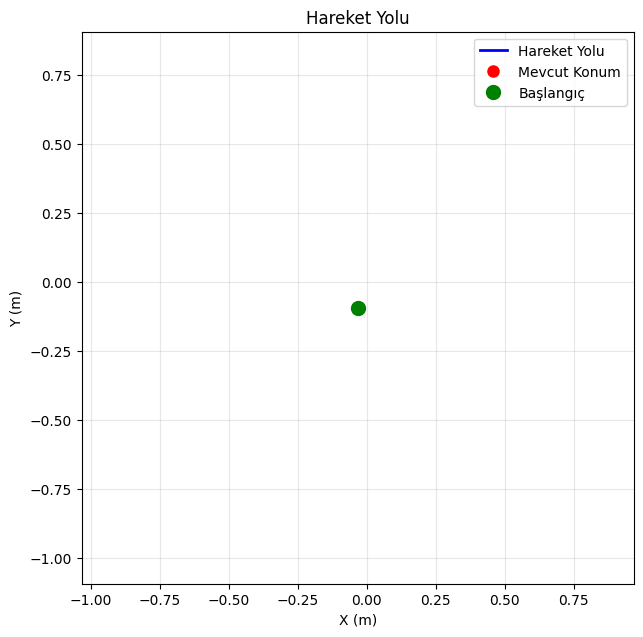

In [1]:
                                                            # BNO055 Hareket Takibi #

import tkinter as tk
from tkinter import ttk, messagebox, scrolledtext
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import serial
import serial.tools.list_ports
import threading
import time
import math
import queue
from datetime import datetime
import numpy as np


class BNO055MotionTracker:
    def __init__(self, root):
        self.root = root
        self.root.title("🎯 BNO055 Motion Tracker")
        self.root.geometry("1200x800")
        self.root.configure(bg='#f0f0f0')
        
        # Seri port değişkenleri
        self.serial_port = None
        self.is_connected = False
        self.serial_thread = None
        self.running = False
        self.data_queue = queue.Queue()
        
        # Takip değişkenleri
        self.is_tracking = False
        self.path = []
        self.current_position = {'x': 0, 'y': 0}
        self.total_distance = 0.0
        self.last_quaternion = {'w': 1.0, 'x': 0.0, 'y': 0.0, 'z': 0.0}
        self.scale = 200  # piksel/m
        
        # GUI oluştur
        self.setup_gui()
        
        # Matplotlib figürü
        self.setup_plot()
        
        # Veri işleme timer
        self.root.after(50, self.process_data)
        
    def setup_gui(self):
        """GUI bileşenlerini oluştur"""
        
        # Ana frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Başlık
        title_label = ttk.Label(main_frame, text="🎯 BNO055 Motion Tracker", 
                               font=('Arial', 16, 'bold'))
        title_label.grid(row=0, column=0, columnspan=3, pady=(0, 10))
        
        # Seri port bağlantı frame
        serial_frame = ttk.LabelFrame(main_frame, text="🔌 Seri Port Bağlantısı", padding="10")
        serial_frame.grid(row=1, column=0, columnspan=3, sticky=(tk.W, tk.E), pady=(0, 10))
        
        # Port seçimi
        ttk.Label(serial_frame, text="Port:").grid(row=0, column=0, padx=(0, 5))
        self.port_var = tk.StringVar()
        self.port_combo = ttk.Combobox(serial_frame, textvariable=self.port_var, width=15)
        self.port_combo.grid(row=0, column=1, padx=(0, 10))
        
        # Baud rate
        ttk.Label(serial_frame, text="Baud Rate:").grid(row=0, column=2, padx=(0, 5))
        self.baud_var = tk.StringVar(value="115200")
        baud_combo = ttk.Combobox(serial_frame, textvariable=self.baud_var, 
                                  values=["9600", "38400", "57600", "115200", "230400"], 
                                  width=10)
        baud_combo.grid(row=0, column=3, padx=(0, 10))
        
        # Bağlantı butonları
        self.connect_btn = ttk.Button(serial_frame, text="🔌 Bağlan", 
                                     command=self.connect_serial)
        self.connect_btn.grid(row=0, column=4, padx=(0, 5))
        
        self.disconnect_btn = ttk.Button(serial_frame, text="🔌 Kes", 
                                        command=self.disconnect_serial, state='disabled')
        self.disconnect_btn.grid(row=0, column=5, padx=(0, 10))
        
        # Port yenile butonu
        refresh_btn = ttk.Button(serial_frame, text="🔄", command=self.refresh_ports)
        refresh_btn.grid(row=0, column=6)
        
        # Bağlantı durumu
        ttk.Label(serial_frame, text="Durum:").grid(row=1, column=0, padx=(0, 5), pady=(5, 0))
        self.status_label = ttk.Label(serial_frame, text="Bağlı Değil", foreground="red")
        self.status_label.grid(row=1, column=1, pady=(5, 0))
        
        # Sensör verisi frame
        sensor_frame = ttk.LabelFrame(main_frame, text="📊 Sensör Verisi", padding="10")
        sensor_frame.grid(row=2, column=0, columnspan=3, sticky=(tk.W, tk.E), pady=(0, 10))
        
        # Quaternion giriş alanları
        quat_frame = ttk.Frame(sensor_frame)
        quat_frame.grid(row=0, column=0, columnspan=4, sticky=(tk.W, tk.E))
        
        ttk.Label(quat_frame, text="Quaternion W:").grid(row=0, column=0, padx=(0, 5))
        self.quat_w_var = tk.StringVar(value="1.0000")
        self.quat_w_entry = ttk.Entry(quat_frame, textvariable=self.quat_w_var, width=10)
        self.quat_w_entry.grid(row=0, column=1, padx=(0, 10))
        
        ttk.Label(quat_frame, text="X:").grid(row=0, column=2, padx=(0, 5))
        self.quat_x_var = tk.StringVar(value="0.0000")
        self.quat_x_entry = ttk.Entry(quat_frame, textvariable=self.quat_x_var, width=10)
        self.quat_x_entry.grid(row=0, column=3, padx=(0, 10))
        
        ttk.Label(quat_frame, text="Y:").grid(row=0, column=4, padx=(0, 5))
        self.quat_y_var = tk.StringVar(value="0.0000")
        self.quat_y_entry = ttk.Entry(quat_frame, textvariable=self.quat_y_var, width=10)
        self.quat_y_entry.grid(row=0, column=5, padx=(0, 10))
        
        ttk.Label(quat_frame, text="Z:").grid(row=0, column=6, padx=(0, 5))
        self.quat_z_var = tk.StringVar(value="0.0000")
        self.quat_z_entry = ttk.Entry(quat_frame, textvariable=self.quat_z_var, width=10)
        self.quat_z_entry.grid(row=0, column=7)
        
        # Ölçek ayarı
        scale_frame = ttk.Frame(sensor_frame)
        scale_frame.grid(row=1, column=0, columnspan=4, sticky=(tk.W, tk.E), pady=(10, 0))
        
        ttk.Label(scale_frame, text="Ölçek:").grid(row=0, column=0, padx=(0, 5))
        self.scale_var = tk.StringVar(value="200")
        scale_entry = ttk.Entry(scale_frame, textvariable=self.scale_var, width=10)
        scale_entry.grid(row=0, column=1, padx=(0, 5))
        ttk.Label(scale_frame, text="piksel/m").grid(row=0, column=2)
        
        # Kontrol butonları
        control_frame = ttk.Frame(main_frame)
        control_frame.grid(row=3, column=0, columnspan=3, pady=(0, 10))
        
        self.start_btn = ttk.Button(control_frame, text="▶️ Takip Başlat", 
                                   command=self.start_tracking)
        self.start_btn.grid(row=0, column=0, padx=(0, 5))
        
        self.stop_btn = ttk.Button(control_frame, text="⏹️ Durdur", 
                                  command=self.stop_tracking, state='disabled')
        self.stop_btn.grid(row=0, column=1, padx=(0, 5))
        
        clear_btn = ttk.Button(control_frame, text="🗑️ Yolu Temizle", 
                              command=self.clear_path)
        clear_btn.grid(row=0, column=2, padx=(0, 5))
        
        reset_btn = ttk.Button(control_frame, text="🔄 Konumu Sıfırla", 
                              command=self.reset_position)
        reset_btn.grid(row=0, column=3)
        
        # Plot frame
        self.plot_frame = ttk.Frame(main_frame)
        self.plot_frame.grid(row=4, column=0, columnspan=2, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Durum bilgisi frame
        status_frame = ttk.LabelFrame(main_frame, text="📊 Durum Bilgisi", padding="10")
        status_frame.grid(row=4, column=2, sticky=(tk.W, tk.E, tk.N, tk.S), padx=(10, 0))
        
        self.tracking_status_label = ttk.Label(status_frame, text="Durum: Durduruldu")
        self.tracking_status_label.grid(row=0, column=0, sticky=tk.W, pady=(0, 5))
        
        self.point_count_label = ttk.Label(status_frame, text="Nokta Sayısı: 0")
        self.point_count_label.grid(row=1, column=0, sticky=tk.W, pady=(0, 5))
        
        self.distance_label = ttk.Label(status_frame, text="Mesafe: 0.00 m")
        self.distance_label.grid(row=2, column=0, sticky=tk.W, pady=(0, 5))
        
        self.position_label = ttk.Label(status_frame, text="Konum: X: 0.00, Y: 0.00")
        self.position_label.grid(row=3, column=0, sticky=tk.W, pady=(0, 10))
        
        # Sensör verisi gösterimi
        sensor_data_label = ttk.Label(status_frame, text="📡 Son Sensör Verisi:")
        sensor_data_label.grid(row=4, column=0, sticky=tk.W, pady=(0, 5))
        
        self.sensor_display = ttk.Label(status_frame, text="Quaternion: w=1.0000, x=0.0000, y=0.0000, z=0.0000",
                                       wraplength=250)
        self.sensor_display.grid(row=5, column=0, sticky=tk.W, pady=(0, 10))
        
        # Log alanı
        log_label = ttk.Label(status_frame, text="📟 Seri Port Log:")
        log_label.grid(row=6, column=0, sticky=tk.W, pady=(0, 5))
        
        self.log_text = scrolledtext.ScrolledText(status_frame, width=35, height=10, 
                                                 font=('Courier', 8))
        self.log_text.grid(row=7, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Grid weight ayarları
        self.root.rowconfigure(0, weight=1)
        self.root.columnconfigure(0, weight=1)
        main_frame.rowconfigure(4, weight=1)
        main_frame.columnconfigure(0, weight=1)
        status_frame.rowconfigure(7, weight=1)
        
        # Portları yükle
        self.refresh_ports()
        
    def setup_plot(self):
        """Matplotlib plot'unu ayarla"""
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.ax.set_xlim(-5, 5)
        self.ax.set_ylim(-5, 5)
        self.ax.set_xlabel('X (m)')
        self.ax.set_ylabel('Y (m)')
        self.ax.set_title('Hareket Yolu')
        self.ax.grid(True, alpha=0.3)
        self.ax.set_aspect('equal')
        
        # Çizgi ve nokta objelerini oluştur
        self.path_line, = self.ax.plot([], [], 'b-', linewidth=2, label='Hareket Yolu')
        self.current_point, = self.ax.plot([], [], 'ro', markersize=8, label='Mevcut Konum')
        self.start_point, = self.ax.plot([], [], 'go', markersize=10, label='Başlangıç')
        
        self.ax.legend()
        
        # Canvas'ı tkinter'a bağla
        self.canvas = FigureCanvasTkAgg(self.fig, self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
    def refresh_ports(self):
        """Mevcut seri portları listele"""
        ports = serial.tools.list_ports.comports()
        port_list = [port.device for port in ports]
        self.port_combo['values'] = port_list
        if port_list:
            self.port_combo.set(port_list[0])
            
    def log_message(self, message):
        """Log mesajı ekle"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        log_entry = f"[{timestamp}] {message}\n"
        
        self.log_text.insert(tk.END, log_entry)
        self.log_text.see(tk.END)
        
    def connect_serial(self):
        """Seri porta bağlan"""
        try:
            port = self.port_var.get()
            baud = int(self.baud_var.get())
            
            if not port:
                messagebox.showerror("Hata", "Lütfen bir port seçin!")
                return
                
            self.serial_port = serial.Serial(port, baud, timeout=1)
            self.is_connected = True
            self.running = True
            
            # Bağlantı durumunu güncelle
            self.status_label.config(text="Bağlı", foreground="green")
            self.connect_btn.config(state='disabled')
            self.disconnect_btn.config(state='normal')
            
            # Seri okuma thread'ini başlat
            self.serial_thread = threading.Thread(target=self.serial_read_thread, daemon=True)
            self.serial_thread.start()
            
            self.log_message(f"ESP32'ye başarıyla bağlandı (Port: {port}, Baud: {baud})")
            
        except Exception as e:
            messagebox.showerror("Bağlantı Hatası", f"Seri porta bağlanılamadı: {str(e)}")
            self.log_message(f"Bağlantı hatası: {str(e)}")
            
    def disconnect_serial(self):
        """Seri port bağlantısını kes"""
        try:
            self.running = False
            self.is_connected = False
            
            if self.serial_port and self.serial_port.is_open:
                self.serial_port.close()
                
            # Bağlantı durumunu güncelle
            self.status_label.config(text="Bağlı Değil", foreground="red")
            self.connect_btn.config(state='normal')
            self.disconnect_btn.config(state='disabled')
            
            self.log_message("ESP32 bağlantısı kesildi")
            
        except Exception as e:
            self.log_message(f"Bağlantı kesme hatası: {str(e)}")
            
    def serial_read_thread(self):
        """Seri port okuma thread'i"""
        buffer = ""
        
        while self.running and self.is_connected:
            try:
                if self.serial_port and self.serial_port.in_waiting > 0:
                    data = self.serial_port.read(self.serial_port.in_waiting).decode('utf-8', errors='ignore')
                    buffer += data
                    
                    # Satır satır işle
                    while '\n' in buffer:
                        line, buffer = buffer.split('\n', 1)
                        line = line.strip()
                        if line:
                            self.data_queue.put(('serial_data', line))
                            
                time.sleep(0.01)  # CPU kullanımını azalt
                
            except Exception as e:
                if self.running:
                    self.data_queue.put(('error', f"Okuma hatası: {str(e)}"))
                break
                
    def parse_serial_data(self, line):
        """Seri veri satırını parse et"""
        self.log_message(f"← {line}")
        
        # Quaternion verisi ara: "Quat = w, x, y, z" formatında
        if "Quat" in line and "=" in line:
            try:
                # "Quat = " kısmını at ve virgülle ayır
                quat_part = line.split("=", 1)[1].strip()
                values = [float(val.strip()) for val in quat_part.split(",")]
                
                if len(values) == 4:
                    w, x, y, z = values
                    
                    # GUI'yi güncelle
                    self.quat_w_var.set(f"{w:.4f}")
                    self.quat_x_var.set(f"{x:.4f}")
                    self.quat_y_var.set(f"{y:.4f}")
                    self.quat_z_var.set(f"{z:.4f}")
                    
                    self.last_quaternion = {'w': w, 'x': x, 'y': y, 'z': z}
                    
                    # Eğer takip aktifse pozisyonu güncelle
                    if self.is_tracking:
                        self.update_position_from_quaternion(w, x, y, z)
                        
            except (ValueError, IndexError) as e:
                self.log_message(f"Veri parse hatası: {str(e)}")
                
    def quaternion_to_position(self, w, x, y, z):
        """Quaternion'dan pozisyon hesapla"""
        # Quaternion'ı normalleştir
        norm = math.sqrt(w*w + x*x + y*y + z*z)
        if norm == 0:
            return {'x': 0, 'y': 0}
            
        w, x, y, z = w/norm, x/norm, y/norm, z/norm
        
        # Basit pozisyon hesaplaması (gerçek uygulamada entegrasyon gerekebilir)
        scale = float(self.scale_var.get()) / 100  # metre cinsinden ölçekleme
        
        # Y ve Z eksenlerindeki rotasyonu pozisyona çevir
        pos_x = (2 * (x*z + w*y)) * scale
        pos_y = (2 * (y*z - w*x)) * scale
        
        return {'x': pos_x, 'y': pos_y}
        
    def update_position_from_quaternion(self, w, x, y, z):
        """Quaternion'dan pozisyonu güncelle"""
        new_pos = self.quaternion_to_position(w, x, y, z)
        
        # Yola ekle
        self.path.append(new_pos)
        
        # Mesafeyi hesapla
        if len(self.path) > 1:
            last_pos = self.path[-2]
            dx = new_pos['x'] - last_pos['x']
            dy = new_pos['y'] - last_pos['y']
            distance = math.sqrt(dx*dx + dy*dy)
            self.total_distance += distance
            
        # Mevcut pozisyonu güncelle
        self.current_position = new_pos
        
        # GUI'yi güncelle
        self.update_status_display(w, x, y, z)
        
    def update_status_display(self, w, x, y, z):
        """Durum gösterimini güncelle"""
        self.sensor_display.config(
            text=f"Quaternion: w={w:.4f}, x={x:.4f}, y={y:.4f}, z={z:.4f}"
        )
        
        self.point_count_label.config(text=f"Nokta Sayısı: {len(self.path)}")
        self.distance_label.config(text=f"Mesafe: {self.total_distance:.2f} m")
        
        if self.path:
            pos = self.path[-1]
            self.position_label.config(
                text=f"Konum: X: {pos['x']:.2f}, Y: {pos['y']:.2f}"
            )
            
    def update_plot(self):
        """Plot'u güncelle"""
        if not self.path:
            return
            
        # Yol verilerini hazırla
        x_data = [pos['x'] for pos in self.path]
        y_data = [pos['y'] for pos in self.path]
        
        # Yolu çiz
        self.path_line.set_data(x_data, y_data)
        
        # Başlangıç noktası
        if len(self.path) > 0:
            self.start_point.set_data([x_data[0]], [y_data[0]])
            
        # Mevcut konum
        if len(self.path) > 0:
            self.current_point.set_data([x_data[-1]], [y_data[-1]])
            
        # Eksenleri otomatik ayarla
        if x_data and y_data:
            margin = 0.5
            x_min, x_max = min(x_data) - margin, max(x_data) + margin
            y_min, y_max = min(y_data) - margin, max(y_data) + margin
            
            # En az 2 birimlik görüş alanı
            if x_max - x_min < 2:
                center = (x_max + x_min) / 2
                x_min, x_max = center - 1, center + 1
            if y_max - y_min < 2:
                center = (y_max + y_min) / 2
                y_min, y_max = center - 1, center + 1
                
            self.ax.set_xlim(x_min, x_max)
            self.ax.set_ylim(y_min, y_max)
            
        self.canvas.draw()
        
    def process_data(self):
        """Veri kuyruğunu işle"""
        try:
            while not self.data_queue.empty():
                data_type, data = self.data_queue.get_nowait()
                
                if data_type == 'serial_data':
                    self.parse_serial_data(data)
                elif data_type == 'error':
                    self.log_message(data)
                    
        except queue.Empty:
            pass
            
        # Plot'u güncelle
        if self.is_tracking:
            self.update_plot()
            
        # Timer'ı yeniden başlat
        self.root.after(50, self.process_data)
        
    def start_tracking(self):
        """Takip başlat"""
        if self.is_tracking:
            return
            
        self.is_tracking = True
        self.start_btn.config(state='disabled')
        self.stop_btn.config(state='normal')
        
        self.tracking_status_label.config(text="Durum: Aktif")
        
        mode = "Gerçek Zamanlı" if self.is_connected else "Manuel Mod"
        self.log_message(f"Hareket takibi başlatıldı ({mode})")
        
    def stop_tracking(self):
        """Takip durdur"""
        if not self.is_tracking:
            return
            
        self.is_tracking = False
        self.start_btn.config(state='normal')
        self.stop_btn.config(state='disabled')
        
        self.tracking_status_label.config(text="Durum: Durduruldu")
        self.log_message("Hareket takibi durduruldu")
        
    def clear_path(self):
        """Yolu temizle"""
        self.path.clear()
        self.total_distance = 0.0
        self.current_position = {'x': 0, 'y': 0}
        
        # Plot'u temizle
        self.path_line.set_data([], [])
        self.current_point.set_data([], [])
        self.start_point.set_data([], [])
        self.canvas.draw()
        
        # Durum bilgilerini sıfırla
        self.point_count_label.config(text="Nokta Sayısı: 0")
        self.distance_label.config(text="Mesafe: 0.00 m")
        self.position_label.config(text="Konum: X: 0.00, Y: 0.00")
        
        self.log_message("Yol temizlendi")
        
    def reset_position(self):
        """Konumu sıfırla"""
        self.quat_w_var.set("1.0000")
        self.quat_x_var.set("0.0000")
        self.quat_y_var.set("0.0000")
        self.quat_z_var.set("0.0000")
        
        self.log_message("Quaternion değerleri sıfırlandı")
        
    def on_closing(self):
        """Uygulama kapatılırken temizlik"""
        if self.is_connected:
            self.disconnect_serial()
        self.root.destroy()


def main():
    """Ana fonksiyon"""
    root = tk.Tk()
    app = BNO055MotionTracker(root)
    
    # Kapatma eventi
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    
    # Uygulamayı başlat
    root.mainloop()


if __name__ == "__main__":
    main()

In [5]:
                                                                   # IR Simülasyon Uygulaması #

from flask import Flask, render_template_string
import webbrowser
import threading
import time

app = Flask(__name__)

HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="tr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>8 Kanallı IR Sensör Simülatörü </title>
    <script src="https://unpkg.com/react@18/umd/react.development.js"></script>
    <script src="https://unpkg.com/react-dom@18/umd/react-dom.development.js"></script>
    <script src="https://unpkg.com/@babel/standalone/babel.min.js"></script>
    <script src="https://cdn.tailwindcss.com"></script>
</head>
<body>
    <div id="root"></div>
    
    <script type="text/babel">
        const { useState, useEffect, useRef } = React;

        const IRSensorSimulator = () => {
          const canvasRef = useRef(null);
          const [objects, setObjects] = useState([]);
          const [robots, setRobots] = useState([]);
          const [draggedItem, setDraggedItem] = useState(null);
          const [nextObjectId, setNextObjectId] = useState(1);
          const [nextRobotId, setNextRobotId] = useState(1);
          const [showFOV, setShowFOV] = useState(true);
          const [fovWidth, setFovWidth] = useState(40); // Varsayılan FOV genişliği
          const [sensorRange, setSensorRange] = useState(200); // Maksimum algılama menzili

          // 8 sensör kanalı için açılar ve FOV ayarları
          const channels = [
            { id: 1, angle: 0, name: 'Kanal 1', fov: fovWidth },
            { id: 2, angle: 45, name: 'Kanal 2', fov: fovWidth },
            { id: 3, angle: 90, name: 'Kanal 3', fov: fovWidth },
            { id: 4, angle: 135, name: 'Kanal 4', fov: fovWidth },
            { id: 5, angle: 180, name: 'Kanal 5', fov: fovWidth },
            { id: 6, angle: 225, name: 'Kanal 6', fov: fovWidth },
            { id: 7, angle: 270, name: 'Kanal 7', fov: fovWidth },
            { id: 8, angle: 315, name: 'Kanal 8', fov: fovWidth }
          ];

          // Canvas boyutları
          const canvasWidth = 700;
          const canvasHeight = 700;
          const centerX = canvasWidth / 2;
          const centerY = canvasHeight / 2;
          const maxSensorRadius = 280;
          const minDetectionRange = 30; // Minimum algılama mesafesi (ölü bölge)

          // Nesne ekleme fonksiyonu
          const addObject = () => {
            const angle = Math.random() * 360;
            const distance = minDetectionRange + 20 + Math.random() * (sensorRange - 50);
            const x = centerX + Math.cos(angle * Math.PI / 180) * distance;
            const y = centerY + Math.sin(angle * Math.PI / 180) * distance;
            
            const shapes = ['circle', 'triangle', 'square'];
            const newObject = {
              id: nextObjectId,
              x: x,
              y: y,
              shape: shapes[Math.floor(Math.random() * shapes.length)],
              size: 15 + Math.random() * 10,
              type: 'object'
            };
            
            setObjects(prev => [...prev, newObject]);
            setNextObjectId(prev => prev + 1);
          };

          // Robot ekleme fonksiyonu
          const addRobot = () => {
            const angle = Math.random() * 360;
            const distance = minDetectionRange + 20 + Math.random() * (sensorRange - 50);
            const x = centerX + Math.cos(angle * Math.PI / 180) * distance;
            const y = centerY + Math.sin(angle * Math.PI / 180) * distance;
            
            const newRobot = {
              id: nextRobotId,
              x: x,
              y: y,
              size: 20,
              type: 'robot'
            };
            
            setRobots(prev => [...prev, newRobot]);
            setNextRobotId(prev => prev + 1);
          };

          // Tüm öğeleri temizle
          const clearAll = () => {
            setObjects([]);
            setRobots([]);
          };

          // Bir noktanın belirli bir FOV içinde olup olmadığını kontrol et
          const isInFOV = (item, channel) => {
            const dx = item.x - centerX;
            const dy = item.y - centerY;
            const distance = Math.sqrt(dx * dx + dy * dy);
            
            // Ölü bölge kontrolü
            if (distance < minDetectionRange) return false;
            
            // Menzil kontrolü
            if (distance > sensorRange) return false;

            let itemAngle = Math.atan2(dy, dx) * 180 / Math.PI;
            if (itemAngle < 0) itemAngle += 360;
            
            // Açıyı 0° üstten başlayacak şekilde ayarla
            itemAngle = (itemAngle + 90) % 360;
            
            // Kanal açısını hesapla
            let channelAngle = channel.angle;
            let angleDiff = Math.abs(itemAngle - channelAngle);
            
            // Açı farkını 180° ile sınırla
            if (angleDiff > 180) angleDiff = 360 - angleDiff;
            
            // FOV içinde mi?
            const halfFOV = channel.fov / 2;
            return angleDiff <= halfFOV;
          };

          // Mesafe bazlı algılama hassasiyeti
          const getDetectionQuality = (item) => {
            const dx = item.x - centerX;
            const dy = item.y - centerY;
            const distance = Math.sqrt(dx * dx + dy * dy);
            
            if (distance < minDetectionRange) return 0; // Ölü bölge
            if (distance > sensorRange) return 0; // Menzil dışı
            
            // Mesafe arttıkça kalite azalır
            const quality = Math.max(0, 1 - (distance / sensorRange));
            return quality;
          };

          // Uzaklık hesapla (FOV ve kalite dikkate alınarak)
          const getDistance = (item) => {
            const dx = item.x - centerX;
            const dy = item.y - centerY;
            const distance = Math.sqrt(dx * dx + dy * dy);
            const quality = getDetectionQuality(item);
            
            // Kalite düşükse uzaklık daha yüksek gösterilir (belirsizlik)
            const adjustedDistance = distance * (1 + (1 - quality) * 0.5);
            return Math.round((adjustedDistance / sensorRange) * 8);
          };

          // Canvas çizim
          useEffect(() => {
            const canvas = canvasRef.current;
            if (!canvas) return;
            
            const ctx = canvas.getContext('2d');
            ctx.clearRect(0, 0, canvasWidth, canvasHeight);
            
            // Arka plan
            ctx.fillStyle = '#f8fafc';
            ctx.fillRect(0, 0, canvasWidth, canvasHeight);
            
            // FOV alanlarını çiz
            if (showFOV) {
              channels.forEach((channel, index) => {
                const halfFOV = channel.fov / 2;
                const startAngle = (channel.angle - halfFOV) * Math.PI / 180 - Math.PI / 2;
                const endAngle = (channel.angle + halfFOV) * Math.PI / 180 - Math.PI / 2;
                
                // FOV alanı
                ctx.beginPath();
                ctx.moveTo(centerX, centerY);
                ctx.arc(centerX, centerY, sensorRange, startAngle, endAngle);
                ctx.closePath();
                
                // Gradient efekti
                const gradient = ctx.createRadialGradient(centerX, centerY, minDetectionRange, centerX, centerY, sensorRange);
                const colors = ['#fee2e2', '#fef3c7', '#ecfdf5', '#fef3c7', '#dbeafe', '#fce7f3', '#f0fdf4', '#fef3c7'];
                gradient.addColorStop(0, 'rgba(255,255,255,0.1)');
                gradient.addColorStop(1, colors[index] + '40');
                
                ctx.fillStyle = gradient;
                ctx.fill();
                
                ctx.strokeStyle = '#64748b';
                ctx.lineWidth = 1;
                ctx.stroke();
                
                // Kanal numarası ve FOV bilgisi
                const labelX = centerX + Math.cos(channel.angle * Math.PI / 180 - Math.PI / 2) * (sensorRange - 40);
                const labelY = centerY + Math.sin(channel.angle * Math.PI / 180 - Math.PI / 2) * (sensorRange - 40);
                
                ctx.fillStyle = '#1e293b';
                ctx.font = 'bold 12px Arial';
                ctx.textAlign = 'center';
                ctx.fillText(`${channel.id}`, labelX, labelY);
                ctx.font = '10px Arial';
                ctx.fillText(`FOV:${channel.fov}°`, labelX, labelY + 15);
              });
            }
            
            // Ölü bölgeyi çiz
            ctx.beginPath();
            ctx.arc(centerX, centerY, minDetectionRange, 0, 2 * Math.PI);
            ctx.fillStyle = 'rgba(239, 68, 68, 0.1)';
            ctx.fill();
            ctx.strokeStyle = '#ef4444';
            ctx.lineWidth = 2;
            ctx.setLineDash([5, 5]);
            ctx.stroke();
            ctx.setLineDash([]);
            
            // Menzil çemberi
            ctx.beginPath();
            ctx.arc(centerX, centerY, sensorRange, 0, 2 * Math.PI);
            ctx.strokeStyle = '#6b7280';
            ctx.lineWidth = 2;
            ctx.setLineDash([10, 10]);
            ctx.stroke();
            ctx.setLineDash([]);
            
            // Merkez IR sensörü
            ctx.beginPath();
            ctx.arc(centerX, centerY, 25, 0, 2 * Math.PI);
            ctx.fillStyle = '#1f2937';
            ctx.fill();
            ctx.strokeStyle = '#111827';
            ctx.lineWidth = 3;
            ctx.stroke();
            
            // IR yazısı
            ctx.fillStyle = 'white';
            ctx.font = 'bold 10px Arial';
            ctx.textAlign = 'center';
            ctx.fillText('IR', centerX, centerY + 3);
            
            // Nesneleri çiz (FOV içinde olanları vurgula)
            objects.forEach(obj => {
              ctx.save();
              ctx.translate(obj.x, obj.y);
              
              // FOV içinde olup olmadığını kontrol et
              const inAnyFOV = channels.some(channel => isInFOV(obj, channel));
              const quality = getDetectionQuality(obj);
              
              // Kaliteye göre opacity ayarla
              ctx.globalAlpha = inAnyFOV ? 1 : 0.3;
              
              if (obj.shape === 'circle') {
                ctx.beginPath();
                ctx.arc(0, 0, obj.size, 0, 2 * Math.PI);
                ctx.fillStyle = inAnyFOV ? '#dc2626' : '#7f1d1d';
                ctx.fill();
                ctx.strokeStyle = inAnyFOV ? '#b91c1c' : '#7f1d1d';
                ctx.lineWidth = inAnyFOV ? 3 : 1;
                ctx.stroke();
              } else if (obj.shape === 'triangle') {
                ctx.beginPath();
                ctx.moveTo(0, -obj.size);
                ctx.lineTo(-obj.size * 0.866, obj.size * 0.5);
                ctx.lineTo(obj.size * 0.866, obj.size * 0.5);
                ctx.closePath();
                ctx.fillStyle = inAnyFOV ? '#2563eb' : '#1e3a8a';
                ctx.fill();
                ctx.strokeStyle = inAnyFOV ? '#1d4ed8' : '#1e3a8a';
                ctx.lineWidth = inAnyFOV ? 3 : 1;
                ctx.stroke();
              } else if (obj.shape === 'square') {
                ctx.fillStyle = inAnyFOV ? '#16a34a' : '#14532d';
                ctx.fillRect(-obj.size, -obj.size, obj.size * 2, obj.size * 2);
                ctx.strokeStyle = inAnyFOV ? '#15803d' : '#14532d';
                ctx.lineWidth = inAnyFOV ? 3 : 1;
                ctx.strokeRect(-obj.size, -obj.size, obj.size * 2, obj.size * 2);
              }
              
              // Kalite göstergesi
              if (inAnyFOV && quality < 0.7) {
                ctx.fillStyle = 'rgba(255, 255, 0, 0.6)';
                ctx.beginPath();
                ctx.arc(obj.size + 5, -obj.size - 5, 4, 0, 2 * Math.PI);
                ctx.fill();
                ctx.fillStyle = 'black';
                ctx.font = '8px Arial';
                ctx.textAlign = 'center';
                ctx.fillText('!', obj.size + 5, -obj.size - 2);
              }
              
              ctx.restore();
            });
            
            // Robotları çiz
            robots.forEach(robot => {
              ctx.save();
              ctx.translate(robot.x, robot.y);
              
              const inAnyFOV = channels.some(channel => isInFOV(robot, channel));
              const quality = getDetectionQuality(robot);
              
              ctx.globalAlpha = inAnyFOV ? 1 : 0.3;
              
              ctx.beginPath();
              ctx.arc(0, 0, robot.size, 0, 2 * Math.PI);
              ctx.fillStyle = inAnyFOV ? '#1f2937' : '#374151';
              ctx.fill();
              ctx.strokeStyle = inAnyFOV ? '#111827' : '#374151';
              ctx.lineWidth = inAnyFOV ? 3 : 1;
              ctx.stroke();
              
              // Robot numarası
              ctx.fillStyle = 'white';
              ctx.font = 'bold 10px Arial';
              ctx.textAlign = 'center';
              ctx.fillText('R', 0, 3);
              
              // Kalite göstergesi
              if (inAnyFOV && quality < 0.7) {
                ctx.fillStyle = 'rgba(255, 255, 0, 0.6)';
                ctx.beginPath();
                ctx.arc(robot.size + 5, -robot.size - 5, 4, 0, 2 * Math.PI);
                ctx.fill();
                ctx.fillStyle = 'black';
                ctx.font = '8px Arial';
                ctx.textAlign = 'center';
                ctx.fillText('!', robot.size + 5, -robot.size - 2);
              }
              
              ctx.restore();
            });
            
            // Ölü bölge etiketi
            ctx.fillStyle = '#ef4444';
            ctx.font = 'bold 12px Arial';
            ctx.textAlign = 'center';
            ctx.fillText('ÖLÜ BÖLGE', centerX, centerY - 40);
            
          }, [objects, robots, showFOV, fovWidth, sensorRange]);

          // Mouse olayları
          const handleMouseDown = (e) => {
            const canvas = canvasRef.current;
            const rect = canvas.getBoundingClientRect();
            const x = e.clientX - rect.left;
            const y = e.clientY - rect.top;
            
            const clickedRobot = robots.find(robot => {
              const dx = x - robot.x;
              const dy = y - robot.y;
              return Math.sqrt(dx * dx + dy * dy) < robot.size;
            });
            
            if (clickedRobot) {
              setDraggedItem({...clickedRobot, itemType: 'robot'});
              return;
            }
            
            const clickedObject = objects.find(obj => {
              const dx = x - obj.x;
              const dy = y - obj.y;
              return Math.sqrt(dx * dx + dy * dy) < obj.size;
            });
            
            if (clickedObject) {
              setDraggedItem({...clickedObject, itemType: 'object'});
            }
          };

          const handleMouseMove = (e) => {
            const canvas = canvasRef.current;
            const rect = canvas.getBoundingClientRect();
            const x = e.clientX - rect.left;
            const y = e.clientY - rect.top;
            
            if (draggedItem) {
              if (draggedItem.itemType === 'robot') {
                setRobots(prev => prev.map(robot => 
                  robot.id === draggedItem.id ? { ...robot, x, y } : robot
                ));
              } else {
                setObjects(prev => prev.map(obj => 
                  obj.id === draggedItem.id ? { ...obj, x, y } : obj
                ));
              }
            }
          };

          const handleMouseUp = () => {
            setDraggedItem(null);
          };

          // Sensör verilerini hesapla (FOV dikkate alınarak)
          const getSensorData = () => {
            const sensorData = {};
            
            channels.forEach(channel => {
              const objectsInFOV = objects.filter(obj => isInFOV(obj, channel));
              const robotsInFOV = robots.filter(robot => isInFOV(robot, channel));
              const allItemsInFOV = [...objectsInFOV, ...robotsInFOV];
              
              let minDistance = 8;
              let detectionQuality = 'Yok';
              
              if (allItemsInFOV.length > 0) {
                const distances = allItemsInFOV.map(item => getDistance(item));
                minDistance = Math.min(...distances);
                
                // En yakın öğenin kalitesini hesapla
                const closestItem = allItemsInFOV.reduce((closest, item) => {
                  const itemDistance = getDistance(item);
                  const closestDistance = getDistance(closest);
                  return itemDistance < closestDistance ? item : closest;
                });
                
                const quality = getDetectionQuality(closestItem);
                if (quality > 0.8) detectionQuality = 'Yüksek';
                else if (quality > 0.5) detectionQuality = 'Orta';
                else detectionQuality = 'Düşük';
              }
              
              sensorData[channel.id] = {
                distance: minDistance,
                objectCount: objectsInFOV.length,
                robotCount: robotsInFOV.length,
                totalCount: allItemsInFOV.length,
                quality: detectionQuality,
                fov: channel.fov
              };
            });
            
            return sensorData;
          };

          const sensorData = getSensorData();

          return React.createElement('div', {
            className: "flex flex-col items-center p-4 bg-gray-50 min-h-screen"
          }, [
            React.createElement('h1', {
              key: 'title',
              className: "text-3xl font-bold mb-4 text-gray-800"
            }, '8 Kanallı IR Sensör Simülatörü - FOV Destekli'),
            
            // Kontrol paneli
            React.createElement('div', {
              key: 'controls',
              className: "bg-white rounded-lg shadow-lg p-4 mb-4 w-full max-w-6xl"
            }, [
              React.createElement('div', {
                key: 'control-row1',
                className: "flex flex-wrap gap-4 items-center justify-center mb-4"
              }, [
                React.createElement('button', {
                  key: 'add-object',
                  onClick: addObject,
                  className: "px-4 py-2 bg-blue-500 text-white rounded-lg hover:bg-blue-600 transition-colors"
                }, 'Nesne Ekle'),
                React.createElement('button', {
                  key: 'add-robot',
                  onClick: addRobot,
                  className: "px-4 py-2 bg-green-500 text-white rounded-lg hover:bg-green-600 transition-colors"
                }, 'Robot Ekle'),
                React.createElement('button', {
                  key: 'clear-all',
                  onClick: clearAll,
                  className: "px-4 py-2 bg-red-500 text-white rounded-lg hover:bg-red-600 transition-colors"
                }, 'Tümünü Temizle'),
                React.createElement('label', {
                  key: 'show-fov',
                  className: "flex items-center gap-2 cursor-pointer"
                }, [
                  React.createElement('input', {
                    key: 'show-fov-checkbox',
                    type: 'checkbox',
                    checked: showFOV,
                    onChange: (e) => setShowFOV(e.target.checked),
                    className: "w-4 h-4"
                  }),
                  React.createElement('span', {
                    key: 'show-fov-text',
                    className: "text-sm font-medium"
                  }, 'FOV Göster')
                ])
              ]),
              React.createElement('div', {
                key: 'control-row2',
                className: "flex flex-wrap gap-6 items-center justify-center"
              }, [
                React.createElement('div', {
                  key: 'fov-control',
                  className: "flex items-center gap-2"
                }, [
                  React.createElement('label', {
                    key: 'fov-label',
                    className: "text-sm font-medium"
                  }, 'FOV Genişliği:'),
                  React.createElement('input', {
                    key: 'fov-slider',
                    type: 'range',
                    min: 15,
                    max: 90,
                    value: fovWidth,
                    onChange: (e) => setFovWidth(parseInt(e.target.value)),
                    className: "w-24"
                  }),
                  React.createElement('span', {
                    key: 'fov-value',
                    className: "text-sm font-bold min-w-[40px]"
                  }, `${fovWidth}°`)
                ]),
                React.createElement('div', {
                  key: 'range-control',
                  className: "flex items-center gap-2"
                }, [
                  React.createElement('label', {
                    key: 'range-label',
                    className: "text-sm font-medium"
                  }, 'Menzil:'),
                  React.createElement('input', {
                    key: 'range-slider',
                    type: 'range',
                    min: 100,
                    max: 300,
                    value: sensorRange,
                    onChange: (e) => setSensorRange(parseInt(e.target.value)),
                    className: "w-24"
                  }),
                  React.createElement('span', {
                    key: 'range-value',
                    className: "text-sm font-bold min-w-[50px]"
                  }, `${sensorRange}px`)
                ])
              ])
            ]),
            
            React.createElement('div', {
              key: 'main',
              className: "flex gap-6 w-full max-w-6xl"
            }, [
              React.createElement('div', {
                key: 'canvas-container',
                className: "bg-white rounded-lg shadow-lg p-4"
              }, [
                React.createElement('canvas', {
                  key: 'canvas',
                  ref: canvasRef,
                  width: canvasWidth,
                  height: canvasHeight,
                  onMouseDown: handleMouseDown,
                  onMouseMove: handleMouseMove,
                  onMouseUp: handleMouseUp,
                  className: "border border-gray-300 cursor-grab active:cursor-grabbing"
                }),
                React.createElement('p', {
                  key: 'instruction',
                  className: "text-sm text-gray-600 mt-2 text-center"
                }, 'Nesneleri sürükleyin. Parlak olanlar FOV içinde, soluk olanlar FOV dışında!')
              ]),
              
              React.createElement('div', {
                key: 'panel',
                className: "bg-white rounded-lg shadow-lg p-4 w-96"
              }, [
                React.createElement('h2', {
                  key: 'panel-title',
                  className: "text-xl font-semibold mb-4 text-gray-800"
                }, 'Sensör Verileri (FOV Tabanlı)'),
                
                React.createElement('div', {
                  key: 'channels',
                  className: "space-y-2 max-h-96 overflow-y-auto"
                }, channels.map(channel => 
                  React.createElement('div', {
                    key: channel.id,
                    className: "p-3 bg-gray-50 rounded border"
                  }, [
                    React.createElement('div', {
                      key: 'channel-header',
                      className: "flex justify-between items-center mb-2"
                    }, [
                      React.createElement('span', {
                        key: 'label',
                        className: "font-semibold text-gray-700"
                      }, `Kanal ${channel.id}`),
                      React.createElement('span', {
                        key: 'distance',
                        className: `px-2 py-1 rounded text-xs font-bold ${
                          sensorData[channel.id].distance <= 2 ? 'bg-red-200 text-red-800' :
                          sensorData[channel.id].distance <= 5 ? 'bg-yellow-200 text-yellow-800' :
                          'bg-green-200 text-green-800'
                        }`
                      }, `${sensorData[channel.id].distance}`)
                    ]),
                    React.createElement('div', {
                      key: 'counts',
                      className: "text-xs text-gray-600 space-y-1"
                    }, [
                      React.createElement('div', {
                        key: 'fov-info',
                        className: "font-medium text-blue-600"
                      }, `FOV: ${sensorData[channel.id].fov}°`),
                      React.createElement('div', {
                        key: 'objects'
                      }, `Nesneler: ${sensorData[channel.id].objectCount}`),
                      React.createElement('div', {
                        key: 'robots'
                      }, `Robotlar: ${sensorData[channel.id].robotCount}`),
                      React.createElement('div', {
                        key: 'total',
                        className: "font-medium"
                      }, `Toplam: ${sensorData[channel.id].totalCount}`),
                      React.createElement('div', {
                        key: 'quality',
                        className: `font-medium ${
                          sensorData[channel.id].quality === 'Yüksek' ? 'text-green-600' :
                          sensorData[channel.id].quality === 'Orta' ? 'text-yellow-600' :
                          sensorData[channel.id].quality === 'Düşük' ? 'text-red-600' :
                          'text-gray-500'
                        }`
                      }, `Kalite: ${sensorData[channel.id].quality}`)
                    ])
                  ])
                )),
                
                React.createElement('div', {
                  key: 'legend',
                  className: "mt-4 p-3 bg-blue-50 rounded text-xs"
                }, [
                  React.createElement('h3', {
                    key: 'legend-title',
                    className: "font-semibold text-blue-800 mb-2"
                  }, 'FOV Özellikleri:'),
                  React.createElement('div', {
                    key: 'legend-content',
                    className: "text-blue-700 space-y-1"
                  }, [
                    React.createElement('div', { key: 'bright' }, '• Parlak nesneler: FOV içinde'),
                    React.createElement('div', { key: 'dim' }, '• Soluk nesneler: FOV dışında'),
                    React.createElement('div', { key: 'warning' }, '• Sarı ünlem: Düşük kalite'),
                    React.createElement('div', { key: 'dead' }, '• Kırmızı alan: Ölü bölge'),
                    React.createElement('div', { key: 'range' }, '• Kesikli çember: Menzil sınırı')
                  ])
                ])
              ])
            ])
          ]);
        };

        ReactDOM.render(React.createElement(IRSensorSimulator), document.getElementById('root'));
    </script>
</body>
</html>
"""

@app.route('/')
def index():
    return render_template_string(HTML_TEMPLATE)

def open_browser():
    """2 saniye sonra tarayıcıyı aç"""
    time.sleep(2)
    webbrowser.open('http://127.0.0.1:5000')

if __name__ == '__main__':
    print("IR Sensör Simülatörü başlatılıyor...")
    print("Tarayıcınız otomatik olarak açılacak...")
    
    # Tarayıcıyı ayrı thread'de aç
    threading.Thread(target=open_browser, daemon=True).start()
    
    # Flask uygulamasını çalıştır
    app.run(debug=True, use_reloader=False)

IR Sensör Simülatörü başlatılıyor...
Tarayıcınız otomatik olarak açılacak...
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [27/Jun/2025 14:20:34] "GET / HTTP/1.1" 200 -


In [4]:
                                                            # IR Kart Simülasyon Robot # 

# İki IR Robotlu Kanal Kesişim Simülatörü #

from flask import Flask, render_template_string
import webbrowser
import threading
import time

app = Flask(__name__)

HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="tr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>İki IR Robotlu Kanal Kesişim Simülatörü</title>
    <script src="https://unpkg.com/react@18/umd/react.development.js"></script>
    <script src="https://unpkg.com/react-dom@18/umd/react-dom.development.js"></script>
    <script src="https://unpkg.com/@babel/standalone/babel.min.js"></script>
    <script src="https://cdn.tailwindcss.com"></script>
</head>
<body>
    <div id="root"></div>
    
    <script type="text/babel">
        const { useState, useEffect, useRef } = React;

        const DualIRRobotSimulator = () => {
          const canvasRef = useRef(null);
          const [draggedRobot, setDraggedRobot] = useState(null);
          const [showFOV, setShowFOV] = useState(true);
          const [fovWidth, setFovWidth] = useState(40);
          const [sensorRange, setSensorRange] = useState(150);
          
          // Ana IR Robot (sabit)
          const mainRobot = {
            id: 'main',
            x: 300,
            y: 300,
            size: 35,
            type: 'main-robot'
          };
          
          // Sürüklenebilir IR Robot
          const [movableRobot, setMovableRobot] = useState({
            id: 'movable',
            x: 500,
            y: 300,
            size: 35,
            type: 'movable-robot'
          });

          // 8 sensör kanalı için açılar (0° yukarı, saat yönünde)
          const channels = [
            { id: 1, angle: 0, name: 'Kanal 1' },      // Yukarı
            { id: 2, angle: 45, name: 'Kanal 2' },     // Sağ üst
            { id: 3, angle: 90, name: 'Kanal 3' },     // Sağ
            { id: 4, angle: 135, name: 'Kanal 4' },    // Sağ alt
            { id: 5, angle: 180, name: 'Kanal 5' },    // Alt
            { id: 6, angle: 225, name: 'Kanal 6' },    // Sol alt
            { id: 7, angle: 270, name: 'Kanal 7' },    // Sol
            { id: 8, angle: 315, name: 'Kanal 8' }     // Sol üst
          ];

          // Canvas boyutları
          const canvasWidth = 800;
          const canvasHeight = 600;

          // İki robot arası mesafe
          const getDistanceBetweenRobots = () => {
            const dx = movableRobot.x - mainRobot.x;
            const dy = movableRobot.y - mainRobot.y;
            return Math.sqrt(dx * dx + dy * dy);
          };

          // Bir noktanın bir açı sektörünün içinde olup olmadığını kontrol et
          const isPointInSector = (px, py, centerX, centerY, angle, halfFOV, range) => {
            const dx = px - centerX;
            const dy = py - centerY;
            const distance = Math.sqrt(dx * dx + dy * dy);
            
            // Mesafe kontrolü
            if (distance > range) return false;
            
            // Açı hesaplama (0° yukarı, saat yönünde)
            let pointAngle = Math.atan2(dx, -dy) * 180 / Math.PI;
            if (pointAngle < 0) pointAngle += 360;
            
            // Açı farkını hesapla
            let angleDiff = Math.abs(pointAngle - angle);
            if (angleDiff > 180) angleDiff = 360 - angleDiff;
            
            return angleDiff <= halfFOV;
          };

          // İki sektörün kesişip kesişmediğini kontrol et
          const doSectorsIntersect = (robot1, channel1, robot2, channel2) => {
            const dx = robot2.x - robot1.x;
            const dy = robot2.y - robot1.y;
            const distance = Math.sqrt(dx * dx + dy * dy);
            
            // Robotlar çok uzaksa kesişim olamaz
            if (distance > sensorRange * 2) return false;
            
            const halfFOV = fovWidth / 2;
            
            // Robot2'nin robot1'in kanalının içinde olup olmadığını kontrol et
            const robot2InRobot1Channel = isPointInSector(
              robot2.x, robot2.y, robot1.x, robot1.y, 
              channel1.angle, halfFOV, sensorRange
            );
            
            // Robot1'in robot2'nin kanalının içinde olup olmadığını kontrol et  
            const robot1InRobot2Channel = isPointInSector(
              robot1.x, robot1.y, robot2.x, robot2.y, 
              channel2.angle, halfFOV, sensorRange
            );
            
            // FOV alanlarının kesişimi için daha detaylı kontrol
            if (robot2InRobot1Channel || robot1InRobot2Channel) {
              return true;
            }
            
            // Sektör kenarlarının kesişimini kontrol et
            const angle1Start = (channel1.angle - halfFOV) * Math.PI / 180;
            const angle1End = (channel1.angle + halfFOV) * Math.PI / 180;
            const angle2Start = (channel2.angle - halfFOV) * Math.PI / 180;
            const angle2End = (channel2.angle + halfFOV) * Math.PI / 180;
            
            // Açı aralıklarının kesişimini kontrol et
            const normalizeAngle = (angle) => {
              while (angle < 0) angle += 2 * Math.PI;
              while (angle >= 2 * Math.PI) angle -= 2 * Math.PI;
              return angle;
            };
            
            const a1s = normalizeAngle(angle1Start);
            const a1e = normalizeAngle(angle1End);
            const a2s = normalizeAngle(angle2Start);
            const a2e = normalizeAngle(angle2End);
            
            // Basit açı kesişimi kontrolü
            const anglesIntersect = (a1s <= a2s && a2s <= a1e) || 
                                  (a1s <= a2e && a2e <= a1e) ||
                                  (a2s <= a1s && a1s <= a2e) ||
                                  (a2s <= a1e && a1e <= a2e);
            
            return distance < sensorRange + robot1.size + robot2.size && anglesIntersect;
          };

          // Bir robotun kanalının diğer robotla kesişip kesişmediğini kontrol et
          const isChannelIntersecting = (robot, channel, targetRobot) => {
            const dx = targetRobot.x - robot.x;
            const dy = targetRobot.y - robot.y;
            const distance = Math.sqrt(dx * dx + dy * dy);
            
            // Mesafe sınırı
            if (distance > sensorRange + targetRobot.size) return false;
            
            const halfFOV = fovWidth / 2;
            
            // Hedef robotun merkezi kanalın içinde mi?
            const targetInChannel = isPointInSector(
              targetRobot.x, targetRobot.y, robot.x, robot.y,
              channel.angle, halfFOV, sensorRange
            );
            
            if (targetInChannel) return true;
            
            // Hedef robotun kenarlarının herhangi biri kanalın içinde mi?
            const angles = [0, 45, 90, 135, 180, 225, 270, 315];
            for (let a of angles) {
              const edgeX = targetRobot.x + Math.cos(a * Math.PI / 180) * targetRobot.size;
              const edgeY = targetRobot.y + Math.sin(a * Math.PI / 180) * targetRobot.size;
              
              if (isPointInSector(edgeX, edgeY, robot.x, robot.y, channel.angle, halfFOV, sensorRange)) {
                return true;
              }
            }
            
            return false;
          };

          // Mesafe kategorisi
          const getDistanceCategory = () => {
            const distance = getDistanceBetweenRobots();
            if (distance < 80) return { level: 1, text: "Çok Yakın", color: "text-red-800" };
            if (distance < 120) return { level: 2, text: "Yakın", color: "text-orange-600" };
            if (distance < 160) return { level: 3, text: "Orta", color: "text-yellow-600" };
            return { level: 4, text: "Uzak", color: "text-green-600" };
          };

          // Canvas çizim
          useEffect(() => {
            const canvas = canvasRef.current;
            if (!canvas) return;
            
            const ctx = canvas.getContext('2d');
            ctx.clearRect(0, 0, canvasWidth, canvasHeight);
            
            // Arka plan
            ctx.fillStyle = '#f8fafc';
            ctx.fillRect(0, 0, canvasWidth, canvasHeight);
            
            // Her iki robot için FOV alanlarını çiz
            [mainRobot, movableRobot].forEach((robot, robotIndex) => {
              if (showFOV) {
                channels.forEach((channel, channelIndex) => {
                  const halfFOV = fovWidth / 2;
                  const startAngle = (channel.angle - halfFOV) * Math.PI / 180 - Math.PI / 2;
                  const endAngle = (channel.angle + halfFOV) * Math.PI / 180 - Math.PI / 2;
                  
                  const otherRobot = robotIndex === 0 ? movableRobot : mainRobot;
                  const isIntersecting = isChannelIntersecting(robot, channel, otherRobot);
                  
                  // FOV alanı
                  ctx.beginPath();
                  ctx.moveTo(robot.x, robot.y);
                  ctx.arc(robot.x, robot.y, sensorRange, startAngle, endAngle);
                  ctx.closePath();
                  
                  // Gradient efekti
                  const gradient = ctx.createRadialGradient(robot.x, robot.y, 20, robot.x, robot.y, sensorRange);
                  
                  if (isIntersecting) {
                    gradient.addColorStop(0, 'rgba(239, 68, 68, 0.4)');
                    gradient.addColorStop(1, 'rgba(239, 68, 68, 0.15)');
                  } else {
                    gradient.addColorStop(0, `rgba(${robotIndex === 0 ? '59, 130, 246' : '16, 185, 129'}, 0.15)`);
                    gradient.addColorStop(1, `rgba(${robotIndex === 0 ? '59, 130, 246' : '16, 185, 129'}, 0.05)`);
                  }
                  
                  ctx.fillStyle = gradient;
                  ctx.fill();
                  
                  ctx.strokeStyle = isIntersecting ? '#ef4444' : robotIndex === 0 ? '#3b82f6' : '#10b981';
                  ctx.lineWidth = isIntersecting ? 3 : 1.5;
                  ctx.stroke();
                  
                  // Kanal numarası
                  const labelDistance = sensorRange - 25;
                  const labelX = robot.x + Math.cos(channel.angle * Math.PI / 180 - Math.PI / 2) * labelDistance;
                  const labelY = robot.y + Math.sin(channel.angle * Math.PI / 180 - Math.PI / 2) * labelDistance;
                  
                  ctx.fillStyle = isIntersecting ? '#ef4444' : robotIndex === 0 ? '#1e40af' : '#047857';
                  ctx.font = 'bold 12px Arial';
                  ctx.textAlign = 'center';
                  ctx.fillText(`${channel.id}`, labelX, labelY);
                  
                  if (isIntersecting) {
                    ctx.font = 'bold 9px Arial';
                    ctx.fillStyle = '#dc2626';
                    ctx.fillText('TESPİT!', labelX, labelY + 15);
                  }
                });
              }
            });
            
            // Robotlar arası bağlantı çizgisi
            const distance = getDistanceBetweenRobots();
            if (distance < sensorRange * 1.5) {
              ctx.beginPath();
              ctx.moveTo(mainRobot.x, mainRobot.y);
              ctx.lineTo(movableRobot.x, movableRobot.y);
              ctx.strokeStyle = distance < 100 ? '#ef4444' : '#6b7280';
              ctx.lineWidth = distance < 100 ? 3 : 2;
              ctx.setLineDash(distance < 100 ? [8, 4] : [4, 2]);
              ctx.stroke();
              ctx.setLineDash([]);
              
              // Mesafe etiketi
              const midX = (mainRobot.x + movableRobot.x) / 2;
              const midY = (mainRobot.y + movableRobot.y) / 2;
              
              ctx.fillStyle = distance < 100 ? 'rgba(239, 68, 68, 0.9)' : 'rgba(107, 114, 128, 0.9)';
              ctx.fillRect(midX - 35, midY - 12, 70, 24);
              ctx.strokeStyle = distance < 100 ? '#dc2626' : '#4b5563';
              ctx.lineWidth = 2;
              ctx.strokeRect(midX - 35, midY - 12, 70, 24);
              ctx.fillStyle = 'white';
              ctx.font = 'bold 11px Arial';
              ctx.textAlign = 'center';
              ctx.fillText(`${Math.round(distance)}px`, midX, midY + 4);
            }
            
            // Ana IR Robot çiz
            ctx.save();
            ctx.translate(mainRobot.x, mainRobot.y);
            
            // Robot gövdesi - Ana robot (mavi tonları)
            ctx.beginPath();
            ctx.arc(0, 0, mainRobot.size, 0, 2 * Math.PI);
            ctx.fillStyle = '#3b82f6';
            ctx.fill();
            ctx.strokeStyle = '#1d4ed8';
            ctx.lineWidth = 3;
            ctx.stroke();
            
            // Ana robot etiketleri
            ctx.fillStyle = 'white';
            ctx.font = 'bold 14px Arial';
            ctx.textAlign = 'center';
            ctx.fillText('ANA', 0, -5);
            ctx.font = 'bold 10px Arial';
            ctx.fillText('IR ROBOT', 0, 8);
            
            // Robot ID
            ctx.fillStyle = 'white';
            ctx.font = 'bold 8px Arial';
            ctx.fillText('R1', 0, 20);
            
            ctx.restore();
            
            // Sürüklenebilir IR Robot çiz
            ctx.save();
            ctx.translate(movableRobot.x, movableRobot.y);
            
            // Robot gövdesi - Sürüklenebilir robot (yeşil tonları)
            ctx.beginPath();
            ctx.arc(0, 0, movableRobot.size, 0, 2 * Math.PI);
            ctx.fillStyle = '#10b981';
            ctx.fill();
            ctx.strokeStyle = '#059669';
            ctx.lineWidth = 3;
            ctx.stroke();
            
            // Sürüklenebilir robot etiketleri
            ctx.fillStyle = 'white';
            ctx.font = 'bold 12px Arial';
            ctx.textAlign = 'center';
            ctx.fillText('MOBIL', 0, -5);
            ctx.font = 'bold 10px Arial';
            ctx.fillText('IR ROBOT', 0, 8);
            
            // Robot ID
            ctx.fillStyle = 'white';
            ctx.font = 'bold 8px Arial';
            ctx.fillText('R2', 0, 20);
            
            // Sürükleme göstergesi
            ctx.beginPath();
            ctx.arc(movableRobot.size + 10, -movableRobot.size - 10, 8, 0, 2 * Math.PI);
            ctx.fillStyle = '#6b7280';
            ctx.fill();
            ctx.fillStyle = 'white';
            ctx.font = 'bold 10px Arial';
            ctx.textAlign = 'center';
            ctx.fillText('↔', movableRobot.size + 10, -movableRobot.size - 6);
            
            ctx.restore();
            
          }, [movableRobot, showFOV, fovWidth, sensorRange]);

          // Mouse olayları
          const handleMouseDown = (e) => {
            const canvas = canvasRef.current;
            const rect = canvas.getBoundingClientRect();
            const x = e.clientX - rect.left;
            const y = e.clientY - rect.top;
            
            // Sadece sürüklenebilir robotu kontrol et
            const dx = x - movableRobot.x;
            const dy = y - movableRobot.y;
            if (Math.sqrt(dx * dx + dy * dy) < movableRobot.size) {
              setDraggedRobot('movable');
            }
          };

          const handleMouseMove = (e) => {
            if (!draggedRobot) return;
            
            const canvas = canvasRef.current;
            const rect = canvas.getBoundingClientRect();
            const x = Math.max(movableRobot.size, Math.min(canvasWidth - movableRobot.size, e.clientX - rect.left));
            const y = Math.max(movableRobot.size, Math.min(canvasHeight - movableRobot.size, e.clientY - rect.top));
            
            setMovableRobot(prev => ({ ...prev, x, y }));
          };

          const handleMouseUp = () => {
            setDraggedRobot(null);
          };

          // Kanal kesişim verilerini hesapla
          const getChannelIntersections = () => {
            const intersections = {
              mainRobot: {},
              movableRobot: {}
            };
            
            channels.forEach(channel => {
              // Ana robotun kanalları
              intersections.mainRobot[channel.id] = {
                intersecting: isChannelIntersecting(mainRobot, channel, movableRobot),
                channel: channel.name
              };
              
              // Sürüklenebilir robotun kanalları
              intersections.movableRobot[channel.id] = {
                intersecting: isChannelIntersecting(movableRobot, channel, mainRobot),
                channel: channel.name
              };
            });
            
            return intersections;
          };

          const intersections = getChannelIntersections();
          const distance = getDistanceBetweenRobots();
          const distanceInfo = getDistanceCategory();
          
          const mainRobotDetections = Object.values(intersections.mainRobot).filter(i => i.intersecting).length;
          const movableRobotDetections = Object.values(intersections.movableRobot).filter(i => i.intersecting).length;
          const totalDetections = mainRobotDetections + movableRobotDetections;
          const hasAnyDetection = totalDetections > 0;

          return React.createElement('div', {
            className: "flex flex-col items-center p-4 bg-gray-50 min-h-screen"
          }, [
            React.createElement('h1', {
              key: 'title',
              className: "text-3xl font-bold mb-4 text-gray-800"
            }, 'İki IR Robotlu Kanal Kesişim Simülatörü'),
            
            // Kontrol paneli
            React.createElement('div', {
              key: 'controls',
              className: "bg-white rounded-lg shadow-lg p-4 mb-4 w-full max-w-7xl"
            }, [
              React.createElement('div', {
                key: 'control-row',
                className: "flex flex-wrap gap-6 items-center justify-center"
              }, [
                React.createElement('label', {
                  key: 'show-fov',
                  className: "flex items-center gap-2 cursor-pointer"
                }, [
                  React.createElement('input', {
                    key: 'show-fov-checkbox',
                    type: 'checkbox',
                    checked: showFOV,
                    onChange: (e) => setShowFOV(e.target.checked),
                    className: "w-4 h-4"
                  }),
                  React.createElement('span', {
                    key: 'show-fov-text',
                    className: "text-sm font-medium"
                  }, 'FOV Göster')
                ]),
                React.createElement('div', {
                  key: 'fov-control',
                  className: "flex items-center gap-2"
                }, [
                  React.createElement('label', {
                    key: 'fov-label',
                    className: "text-sm font-medium"
                  }, 'FOV Genişliği:'),
                  React.createElement('input', {
                    key: 'fov-slider',
                    type: 'range',
                    min: 15,
                    max: 90,
                    value: fovWidth,
                    onChange: (e) => setFovWidth(parseInt(e.target.value)),
                    className: "w-24"
                  }),
                  React.createElement('span', {
                    key: 'fov-value',
                    className: "text-sm font-bold min-w-[40px]"
                  }, `${fovWidth}°`)
                ]),
                React.createElement('div', {
                  key: 'range-control',
                  className: "flex items-center gap-2"
                }, [
                  React.createElement('label', {
                    key: 'range-label',
                    className: "text-sm font-medium"
                  }, 'Sensör Menzili:'),
                  React.createElement('input', {
                    key: 'range-slider',
                    type: 'range',
                    min: 80,
                    max: 250,
                    value: sensorRange,
                    onChange: (e) => setSensorRange(parseInt(e.target.value)),
                    className: "w-24"
                  }),
                  React.createElement('span', {
                    key: 'range-value',
                    className: "text-sm font-bold min-w-[50px]"
                  }, `${sensorRange}px`)
                ])
              ])
            ]),
            
            React.createElement('div', {
              key: 'main',
              className: "flex gap-6 w-full max-w-7xl"
            }, [
              React.createElement('div', {
                key: 'canvas-container',
                className: "bg-white rounded-lg shadow-lg p-4"
              }, [
                React.createElement('canvas', {
                  key: 'canvas',
                  ref: canvasRef,
                  width: canvasWidth,
                  height: canvasHeight,
                  onMouseDown: handleMouseDown,
                  onMouseMove: handleMouseMove,
                  onMouseUp: handleMouseUp,
                  className: "border-2 border-gray-300 cursor-grab active:cursor-grabbing"
                }),
                React.createElement('p', {
                  key: 'instruction',
                  className: "text-sm text-gray-600 mt-2 text-center"
                }, 'Yeşil robotu sürükleyerek mavi robotla kesişimini test edin!')
              ]),
              
              React.createElement('div', {
                key: 'info-panel',
                className: "bg-white rounded-lg shadow-lg p-4 w-96 space-y-4"
              }, [
                React.createElement('h2', {
                  key: 'panel-title',
                  className: "text-xl font-semibold text-gray-800"
                }, 'Kanal Kesişim Durumu'),
                
                // Genel durum
                React.createElement('div', {
                  key: 'general-status',
                  className: `p-4 rounded-lg border-2 ${
                    hasAnyDetection 
                      ? 'bg-red-50 border-red-300' 
                      : 'bg-gray-50 border-gray-300'
                  }`
                }, [
                  React.createElement('div', {
                    key: 'detection-status',
                    className: `text-lg font-bold ${
                      hasAnyDetection ? 'text-red-700' : 'text-gray-600'
                    }`
                  }, hasAnyDetection ? 'ROBOT TESPİT EDİLDİ!' : 'Robot Tespit Edilmedi'),
                  React.createElement('div', {
                    key: 'distance-info',
                    className: `text-sm mt-1 ${distanceInfo.color}`
                  }, `Mesafe: ${Math.round(distance)}px (${distanceInfo.text})`),
                  hasAnyDetection && React.createElement('div', {
                    key: 'detection-count',
                    className: "text-sm text-red-600 mt-2 font-semibold"
                  }, `Toplam ${totalDetections} Kanal Kesişimi Tespit Edildi`)
                ]),
                
                // Ana robot kanalları
                React.createElement('div', {
                  key: 'main-robot-channels',
                  className: "space-y-2"
                }, [
                  React.createElement('h3', {
                    key: 'main-title',
                    className: "font-semibold text-blue-700 border-b border-blue-200 pb-1"
                  }, `Ana IR Robot (R1) - ${mainRobotDetections} Kanal Aktif`),
                  React.createElement('div', {
                    key: 'main-grid',
                    className: "grid grid-cols-2 gap-2"
                  }, channels.map(channel => 
                    React.createElement('div', {
                      key: `main-${channel.id}`,
                      className: `p-2 rounded text-xs ${
                        intersections.mainRobot[channel.id].intersecting
                          ? 'bg-red-100 border border-red-300 text-red-800'
                          : 'bg-blue-50 border border-blue-200 text-blue-700'
                      }`
                    }, [
                      React.createElement('div', {
                        key: 'channel-info',
                        className: "font-semibold"
                      }, `Kanal ${channel.id}`),
                      React.createElement('div', {
                        key: 'status',
                        className: "mt-1"
                      }, intersections.mainRobot[channel.id].intersecting ? 'ROBOT TESPİT!' : 'Normal')
                    ])
                  ))
                ]),
                
                // Sürüklenebilir robot kanalları
                React.createElement('div', {
                  key: 'movable-robot-channels',
                  className: "space-y-2"
                }, [
                  React.createElement('h3', {
                    key: 'movable-title',
                    className: "font-semibold text-green-700 border-b border-green-200 pb-1"
                  }, `Mobil IR Robot (R2) - ${movableRobotDetections} Kanal Aktif`),
                  React.createElement('div', {
                    key: 'movable-grid',
                    className: "grid grid-cols-2 gap-2"
                  }, channels.map(channel => 
                    React.createElement('div', {
                      key: `movable-${channel.id}`,
                      className: `p-2 rounded text-xs ${
                        intersections.movableRobot[channel.id].intersecting
                          ? 'bg-red-100 border border-red-300 text-red-800'
                          : 'bg-green-50 border border-green-200 text-green-700'
                      }`
                    }, [
                      React.createElement('div', {
                        key: 'channel-info',
                        className: "font-semibold"
                      }, `Kanal ${channel.id}`),
                      React.createElement('div', {
                        key: 'status',
                        className: "mt-1"
                      }, intersections.movableRobot[channel.id].intersecting ? 'ROBOT TESPİT!' : 'Normal')
                    ])
                  ))
                ]),
                
                // Açıklama
                React.createElement('div', {
                  key: 'legend',
                  className: "p-3 bg-blue-50 rounded text-xs border border-blue-200"
                }, [
                  React.createElement('h3', {
                    key: 'legend-title',
                    className: "font-semibold text-blue-800 mb-2"
                  }, 'Simülasyon Açıklaması:'),
                  React.createElement('div', {
                    key: 'legend-content',
                    className: "text-blue-700 space-y-1"
                  }, [
                    React.createElement('div', { key: 'main-robot' }, '• Mavi Robot (R1): Ana IR sensör robotu'),
                    React.createElement('div', { key: 'movable-robot' }, '• Yeşil Robot (R2): Sürüklenebilir IR robot'),
                    React.createElement('div', { key: 'channels' }, '• Her robot 8 kanallı IR sensöre sahip'),
                    React.createElement('div', { key: 'intersection' }, '• Robotlar çakıştığında kanal kesişimi tespit edilir'),
                    React.createElement('div', { key: 'distance' }, '• Kırmızı çizgi: Robot-robot arası mesafe')
                  ])
                ])
              ])
            ])
          ]);
        };

        ReactDOM.render(React.createElement(DualIRRobotSimulator), document.getElementById('root'));
    </script>
</body>
</html>
"""

@app.route('/')
def index():
    return render_template_string(HTML_TEMPLATE)

def open_browser():
    """2 saniye sonra tarayıcıyı aç"""
    time.sleep(2)
    webbrowser.open('http://127.0.0.1:5000')

if __name__ == '__main__':
    print("İki IR Robotlu Kanal Kesişim Simülatörü başlatılıyor...")
    print("Tarayıcınız otomatik olarak açılacak...")
    
    # Tarayıcıyı ayrı thread'de aç
    threading.Thread(target=open_browser, daemon=True).start()
    
    # Flask uygulamasını çalıştır
    app.run(debug=True, use_reloader=False)

İki IR Robotlu Kanal Kesişim Simülatörü başlatılıyor...
Tarayıcınız otomatik olarak açılacak...
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [8]:
                                                            # IR Kart Gerçek Veriler İle Uygulaması #

from flask import Flask, render_template_string, jsonify
import webbrowser
import threading
import time
from esp32bot import ESP32bot

app = Flask(__name__)

# Global değişkenler
ir_data = {
    "raw_data": 0,
    "distance_levels": [8, 8, 8, 8, 8, 8, 8, 8],
    "robot_detected": [0, 0, 0, 0, 0, 0, 0, 0]
}

robot = None

HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="tr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>8 Kanallı IR Sensör </title>
    <script src="https://unpkg.com/react@18/umd/react.development.js"></script>
    <script src="https://unpkg.com/react-dom@18/umd/react-dom.development.js"></script>
    <script src="https://unpkg.com/@babel/standalone/babel.min.js"></script>
    <script src="https://cdn.tailwindcss.com"></script>
</head>
<body>
    <div id="root"></div>
    
    <script type="text/babel">
        const { useState, useEffect, useRef } = React;

        const IRSensorLive = () => {
          const canvasRef = useRef(null);
          const [sensorData, setSensorData] = useState({
            raw_data: 0,
            distance_levels: [8, 8, 8, 8, 8, 8, 8, 8],
            robot_detected: [0, 0, 0, 0, 0, 0, 0, 0]
          });
          const [lastUpdate, setLastUpdate] = useState(new Date());
          const [fovWidth, setFovWidth] = useState(40); // FOV genişliği (derece)
          const [range, setRange] = useState(200); // Menzil (piksel)

          // 8 sensör kanalı için açılar (0° üstten başlayarak saat yönünde)
          const channels = [
            { id: 1, angle: 0, name: 'Kanal 1' },
            { id: 2, angle: 45, name: 'Kanal 2' },
            { id: 3, angle: 90, name: 'Kanal 3' },
            { id: 4, angle: 135, name: 'Kanal 4' },
            { id: 5, angle: 180, name: 'Kanal 5' },
            { id: 6, angle: 225, name: 'Kanal 6' },
            { id: 7, angle: 270, name: 'Kanal 7' },
            { id: 8, angle: 315, name: 'Kanal 8' }
          ];

          // Canvas boyutları
          const canvasWidth = 600;
          const canvasHeight = 600;
          const centerX = canvasWidth / 2;
          const centerY = canvasHeight / 2;
          const maxRadius = Math.min(canvasWidth, canvasHeight) / 2 - 50;

          // Verileri 2 saniyede bir güncelle
          useEffect(() => {
            const fetchData = async () => {
              try {
                const response = await fetch('/api/ir-data');
                const data = await response.json();
                setSensorData(data);
                setLastUpdate(new Date());
              } catch (error) {
                console.error('Veri alınırken hata:', error);
              }
            };

            // İlk veriyi al
            fetchData();
            
            // 2 saniyede bir güncelle
            const interval = setInterval(fetchData, 2000);
            
            return () => clearInterval(interval);
          }, []);

          // Mesafe değerine göre nesne pozisyonu hesapla
          const getObjectPosition = (channelIndex, distance) => {
            const channel = channels[channelIndex];
            // Distance 1-8 arası, 1 en yakın, 8 en uzak
            // Menzil ayarına göre pozisyonlandır
            const distanceRatio = 0.2 + (distance - 1) * (0.7 / 7);
            const objectRadius = (range * distanceRatio);
            
            const angleRad = (channel.angle - 90) * Math.PI / 180; // Canvas koordinat sistemine göre ayarla
            const x = centerX + Math.cos(angleRad) * objectRadius;
            const y = centerY + Math.sin(angleRad) * objectRadius;
            
            return { x, y };
          };

          // Canvas çizim
          useEffect(() => {
            const canvas = canvasRef.current;
            if (!canvas) return;
            
            const ctx = canvas.getContext('2d');
            ctx.clearRect(0, 0, canvasWidth, canvasHeight);
            
            // Arka plan
            ctx.fillStyle = '#f8f9fa';
            ctx.fillRect(0, 0, canvasWidth, canvasHeight);
            
            // Her kanal için FOV alanı çiz
            channels.forEach((channel, index) => {
              const halfFov = fovWidth / 2;
              const startAngle = (channel.angle - halfFov) * Math.PI / 180 - Math.PI / 2;
              const endAngle = (channel.angle + halfFov) * Math.PI / 180 - Math.PI / 2;
              
              // FOV alanı
              ctx.beginPath();
              ctx.moveTo(centerX, centerY);
              ctx.arc(centerX, centerY, range, startAngle, endAngle);
              ctx.closePath();
              
              // Kanal durumuna göre renklendirme
              const distance = sensorData.distance_levels[index];
              const hasObject = distance < 8;
              const isRobot = sensorData.robot_detected[index] === 1;
              
              if (isRobot) {
                ctx.fillStyle = 'rgba(231, 76, 60, 0.3)'; // Kırmızı - Robot algılandı
              } else if (hasObject) {
                ctx.fillStyle = 'rgba(52, 152, 219, 0.3)'; // Mavi - Nesne var
              } else {
                ctx.fillStyle = 'rgba(149, 165, 166, 0.2)'; // Gri - Nesne yok
              }
              
              ctx.fill();
              
              // FOV sınır çizgileri
              ctx.strokeStyle = hasObject ? (isRobot ? '#e74c3c' : '#3498db') : '#95a5a6';
              ctx.lineWidth = 2;
              ctx.stroke();
              
              // Kanal numarası ve FOV bilgisi
              const labelRadius = range - 30;
              const labelX = centerX + Math.cos(channel.angle * Math.PI / 180 - Math.PI / 2) * labelRadius;
              const labelY = centerY + Math.sin(channel.angle * Math.PI / 180 - Math.PI / 2) * labelRadius;
              
              ctx.fillStyle = '#2c3e50';
              ctx.font = 'bold 12px Arial';
              ctx.textAlign = 'center';
              ctx.fillText(channel.id.toString(), labelX, labelY - 10);
              
              ctx.font = '10px Arial';
              ctx.fillText(`FOV:${fovWidth}°`, labelX, labelY + 5);
            });
            
            // Menzil çemberleri çiz (mesafe referansı için)
            const ringCount = 4;
            for (let i = 1; i <= ringCount; i++) {
              const ringRadius = (range / ringCount) * i;
              ctx.beginPath();
              ctx.arc(centerX, centerY, ringRadius, 0, 2 * Math.PI);
              ctx.strokeStyle = '#ecf0f1';
              ctx.lineWidth = 1;
              ctx.setLineDash([5, 5]);
              ctx.stroke();
              ctx.setLineDash([]);
              
              // Menzil etiketi
              ctx.fillStyle = '#7f8c8d';
              ctx.font = '9px Arial';
              ctx.textAlign = 'center';
              ctx.fillText(`${Math.round((ringRadius / range) * 8)}`, centerX + ringRadius - 15, centerY - 5);
            }
            
            // Algılanan nesneleri çiz
            sensorData.distance_levels.forEach((distance, index) => {
              if (distance < 8) { // Sadece 8'den küçük değerler için nesne çiz
                const { x, y } = getObjectPosition(index, distance);
                const isRobotDetected = sensorData.robot_detected[index] === 1;
                
                ctx.beginPath();
                ctx.arc(x, y, 12, 0, 2 * Math.PI);
                
                // Robot algılandıysa kırmızı, değilse mesafeye göre renk
                if (isRobotDetected) {
                  ctx.fillStyle = '#e74c3c';
                  ctx.strokeStyle = '#c0392b';
                } else {
                  // Mesafeye göre renk (yakın = koyu, uzak = açık)
                  const intensity = 1 - (distance - 1) / 7;
                  const green = Math.floor(100 + intensity * 155);
                  const blue = Math.floor(100 + intensity * 155);
                  ctx.fillStyle = `rgb(70, ${green}, ${blue})`;
                  ctx.strokeStyle = `rgb(50, ${green - 20}, ${blue - 20})`;
                }
                
                ctx.fill();
                ctx.lineWidth = 2;
                ctx.stroke();
                
                // Mesafe değerini nesnenin üzerine yaz
                ctx.fillStyle = 'white';
                ctx.font = 'bold 9px Arial';
                ctx.textAlign = 'center';
                ctx.fillText(distance.toString(), x, y + 3);
              }
            });
            
            // Merkez IR sensörü
            ctx.beginPath();
            ctx.arc(centerX, centerY, 20, 0, 2 * Math.PI);
            ctx.fillStyle = '#2c3e50';
            ctx.fill();
            ctx.strokeStyle = '#1a252f';
            ctx.lineWidth = 3;
            ctx.stroke();
            
            // "ÖLÜ BÖLGE" yazısı
            ctx.fillStyle = 'white';
            ctx.font = 'bold 8px Arial';
            ctx.textAlign = 'center';
            ctx.fillText('ÖLÜ BÖLGE', centerX, centerY - 2);
            ctx.fillText('IR', centerX, centerY + 8);
            
          }, [sensorData, fovWidth, range]);

          return React.createElement('div', {
            className: "flex flex-col items-center p-4 bg-gray-100 min-h-screen"
          }, [
            React.createElement('h1', {
              key: 'title',
              className: "text-2xl font-bold mb-4 text-gray-800"
            }, '8 Kanallı IR Sensör - FOV Ayarlı'),
            
            // FOV ve Menzil Kontrolleri
            React.createElement('div', {
              key: 'controls',
              className: "mb-4 bg-white rounded-lg shadow p-4 flex gap-6 items-center"
            }, [
              React.createElement('div', {
                key: 'fov-control',
                className: "flex items-center gap-3"
              }, [
                React.createElement('label', {
                  key: 'fov-label',
                  className: "font-medium text-gray-700"
                }, 'FOV Genişliği:'),
                React.createElement('input', {
                  key: 'fov-slider',
                  type: 'range',
                  min: 10,
                  max: 90,
                  value: fovWidth,
                  onChange: (e) => setFovWidth(parseInt(e.target.value)),
                  className: "w-32"
                }),
                React.createElement('span', {
                  key: 'fov-value',
                  className: "bg-blue-100 px-2 py-1 rounded text-sm font-medium"
                }, `${fovWidth}°`)
              ]),
              React.createElement('div', {
                key: 'range-control',
                className: "flex items-center gap-3"
              }, [
                React.createElement('label', {
                  key: 'range-label',
                  className: "font-medium text-gray-700"
                }, 'Menzil:'),
                React.createElement('input', {
                  key: 'range-slider',
                  type: 'range',
                  min: 100,
                  max: 250,
                  value: range,
                  onChange: (e) => setRange(parseInt(e.target.value)),
                  className: "w-32"
                }),
                React.createElement('span', {
                  key: 'range-value',
                  className: "bg-green-100 px-2 py-1 rounded text-sm font-medium"
                }, `${range}px`)
              ])
            ]),
            
            React.createElement('div', {
              key: 'main',
              className: "flex gap-6"
            }, [
              React.createElement('div', {
                key: 'canvas-container',
                className: "bg-white rounded-lg shadow-lg p-4"
              }, [
                React.createElement('canvas', {
                  key: 'canvas',
                  ref: canvasRef,
                  width: canvasWidth,
                  height: canvasHeight,
                  className: "border border-gray-300"
                }),
                React.createElement('p', {
                  key: 'update-time',
                  className: "text-sm text-gray-600 mt-2 text-center"
                }, `Son Güncelleme: ${lastUpdate.toLocaleTimeString()}`),
                React.createElement('p', {
                  key: 'info',
                  className: "text-xs text-gray-500 mt-1 text-center"
                }, 'Nesneleri sürükleyin. Parlak nesneler FOV içinde, soluk olanlar FOV dışında!')
              ]),
              
              React.createElement('div', {
                key: 'panel',
                className: "space-y-4"
              }, [
                // Sensör Verileri Paneli (FOV Tabanlı)
                React.createElement('div', {
                  key: 'sensor-panel',
                  className: "bg-white rounded-lg shadow-lg p-4 w-80"
                }, [
                  React.createElement('h2', {
                    key: 'panel-title',
                    className: "text-lg font-semibold mb-3 text-gray-800"
                  }, 'Sensör Verileri (FOV Tabanlı)'),
                  
                  React.createElement('div', {
                    key: 'channels',
                    className: "space-y-2 max-h-64 overflow-y-auto"
                  }, channels.map((channel, index) => {
                    const distance = sensorData.distance_levels[index];
                    const hasObject = distance < 8;
                    const isRobot = sensorData.robot_detected[index] === 1;
                    const quality = hasObject ? (distance <= 2 ? 'Yüksek' : distance <= 5 ? 'Orta' : 'Düşük') : 'Yok';
                    
                    return React.createElement('div', {
                      key: channel.id,
                      className: "p-3 bg-gray-50 rounded-lg"
                    }, [
                      React.createElement('div', {
                        key: 'header',
                        className: "flex justify-between items-center mb-2"
                      }, [
                        React.createElement('span', {
                          key: 'label',
                          className: "font-medium text-sm"
                        }, `Kanal ${channel.id}`),
                        React.createElement('span', {
                          key: 'distance-badge',
                          className: `px-2 py-1 rounded text-xs font-bold ${distance === 8 ? 'bg-gray-200 text-gray-600' : distance <= 2 ? 'bg-red-200 text-red-800' : distance <= 5 ? 'bg-yellow-200 text-yellow-800' : 'bg-green-200 text-green-800'}`
                        }, distance === 8 ? '∞' : distance)
                      ]),
                      React.createElement('div', {
                        key: 'details',
                        className: "text-xs text-gray-600 space-y-1"
                      }, [
                        React.createElement('div', { key: 'fov' }, `FOV: ${fovWidth}°`),
                        React.createElement('div', { key: 'objects' }, `Nesne: ${hasObject ? distance : '0'}`),
                        React.createElement('div', { key: 'robot' }, `Robot: ${isRobot ? '1' : '0'}`),
                        React.createElement('div', { key: 'total' }, `Toplam: ${hasObject ? '1' : '0'}`),
                        React.createElement('div', { key: 'quality' }, `Kalite: ${quality}`)
                      ]),
                      isRobot && React.createElement('div', {
                        key: 'robot-alert',
                        className: "mt-2 px-2 py-1 bg-red-500 text-white text-xs font-bold rounded text-center"
                      }, 'ROBOT ALGıLANDı')
                    ]);
                  }))
                ]),
                
                // FOV Özellikleri Paneli
                React.createElement('div', {
                  key: 'fov-panel',
                  className: "bg-white rounded-lg shadow-lg p-4 w-80"
                }, [
                  React.createElement('h3', {
                    key: 'fov-title',
                    className: "text-lg font-semibold text-gray-800 mb-3"
                  }, 'FOV Özellikleri'),
                  React.createElement('div', {
                    key: 'fov-info',
                    className: "text-sm text-gray-700 space-y-2"
                  }, [
                    React.createElement('div', { key: 'fov-bright' }, '• Parlak nesneler: FOV içinde'),
                    React.createElement('div', { key: 'fov-dim' }, '• Soluk nesneler: FOV dışında'),
                    React.createElement('div', { key: 'fov-red' }, '• Sarı ünlem: Düşük kalite'),
                    React.createElement('div', { key: 'fov-border' }, '• Kırmızı alan: Ölü bölge'),
                    React.createElement('div', { key: 'fov-cut' }, '• Kesikli çember: Menzil sınırı')
                  ])
                ]),
                
                // Ham Veri Paneli
                React.createElement('div', {
                  key: 'raw-panel',
                  className: "bg-white rounded-lg shadow-lg p-4 w-80"
                }, [
                  React.createElement('h2', {
                    key: 'raw-title',
                    className: "text-lg font-semibold mb-3 text-gray-800"
                  }, 'Ham Veri'),
                  
                  React.createElement('div', {
                    key: 'raw-data',
                    className: "bg-gray-100 p-3 rounded font-mono text-xs"
                  }, [
                    React.createElement('div', {
                      key: 'raw-value'
                    }, `Raw Data: ${sensorData.raw_data}`),
                    React.createElement('div', {
                      key: 'distance-array',
                      className: "mt-2"
                    }, `Distance: [${sensorData.distance_levels.join(',')}]`),
                    React.createElement('div', {
                      key: 'robot-array',
                      className: "mt-2"
                    }, `Robot: [${sensorData.robot_detected.join(',')}]`)
                  ])
                ])
              ])
            ])
          ]);
        };

        ReactDOM.render(React.createElement(IRSensorLive), document.getElementById('root'));
    </script>
</body>
</html>
"""

@app.route('/')
def index():
    return render_template_string(HTML_TEMPLATE)

@app.route('/api/ir-data')
def get_ir_data():
    return jsonify(ir_data)

def ir_data_reader():
    """IR verilerini sürekli okuyan thread"""
    global robot, ir_data
    import json
    import re
    
    try:
        robot = ESP32bot("192.168.195.19")
        print("ESP32 bağlantısı başarılı!")
        
        while True:
            try:
                # IR verisini oku - artık _wait_for_response ile gerçek veri alacak
                result = robot.ir_read()
                print(f"Ham IR verisi: {result}")
                print(f"IR verisi tipi: {type(result)}")
                
                if result:
                    # String formatında gelen veriyi parse et
                    if isinstance(result, str):
                        try:
                            # Direkt JSON string olabilir
                            if result.startswith('{') and result.endswith('}'):
                                parsed_result = json.loads(result)
                                ir_data.update(parsed_result)
                                print(f"JSON parse edildi: {ir_data}")
                                
                            # JSON string'i arama ile bul
                            else:
                                json_match = re.search(r'\{[^}]+\}', result)
                                if json_match:
                                    json_str = json_match.group()
                                    # raw_data yoksa ekle
                                    if '"raw_data"' not in json_str:
                                        json_str = json_str.replace('{', '{"raw_data": 0, ', 1)
                                    parsed_result = json.loads(json_str)
                                    ir_data.update(parsed_result)
                                    print(f"Regex ile JSON parse edildi: {ir_data}")
                                else:
                                    # Manuel regex parse denemesi
                                    distance_match = re.search(r'"distance_levels":\s*\[([^\]]+)\]', result)
                                    robot_match = re.search(r'"robot_detected":\s*\[([^\]]+)\]', result)
                                    raw_match = re.search(r'"raw_data":\s*(\d+)', result)
                                    
                                    if distance_match and robot_match:
                                        distance_str = distance_match.group(1)
                                        robot_str = robot_match.group(1)
                                        raw_data = int(raw_match.group(1)) if raw_match else 0
                                        
                                        distance_levels = [int(x.strip()) for x in distance_str.split(',')]
                                        robot_detected = [int(x.strip()) for x in robot_str.split(',')]
                                        
                                        ir_data.update({
                                            "raw_data": raw_data,
                                            "distance_levels": distance_levels,
                                            "robot_detected": robot_detected
                                        })
                                        print(f"Manuel regex parse edildi: {ir_data}")
                                    else:
                                        print("Veri formatı tanınamadı, ham veri:")
                                        print(repr(result))
                            
                        except Exception as parse_error:
                            print(f"Parse hatası: {parse_error}")
                            print(f"Ham veri: {repr(result)}")
                    
                    # Dict formatında gelirse direkt kullan
                    elif isinstance(result, dict):
                        ir_data.update(result)
                        print(f"Dict verisi güncellendi: {ir_data}")
                    
                    else:
                        print(f"Beklenmeyen veri formatı: {type(result)}")
                        print(f"Veri içeriği: {repr(result)}")
                        
                else:
                    print("ESP32'den veri alınamadı (None döndü)")
                        
            except Exception as e:
                print(f"IR okuma hatası: {e}")
                import traceback
                traceback.print_exc()
            
              
            
    except Exception as e:
        print(f"ESP32 bağlantı hatası: {e}")
        import traceback
        traceback.print_exc()
        # Test verisi kullan
        import random
        print("Test verisi modu başlatılıyor...")
        while True:
            ir_data = {
                "raw_data": random.randint(1000000, 9999999),
                "distance_levels": [random.randint(1, 8) for _ in range(8)],
                "robot_detected": [random.randint(0, 1) for _ in range(8)]
            }
            print(f"Test verisi: {ir_data}")
            time.sleep(2)

def open_browser():
    """2 saniye sonra tarayıcıyı aç"""
    time.sleep(2)
    webbrowser.open('http://127.0.0.1:5000')

if __name__ == '__main__':
    print("IR Sensör FOV Destekli Uygulama başlatılıyor...")
    print("ESP32 bağlantısı kuruluyor...")
    
    # IR veri okuma thread'ini başlat
    ir_thread = threading.Thread(target=ir_data_reader, daemon=True)
    ir_thread.start()
    
    # Tarayıcıyı ayrı thread'de aç
    threading.Thread(target=open_browser, daemon=True).start()
    
    print("Tarayıcınız otomatik olarak açılacak...")
    print("Ctrl+C ile çıkış yapabilirsiniz.")
    
    # Flask uygulamasını çalıştır
    app.run(debug=False, use_reloader=False)

IR Sensör FOV Destekli Uygulama başlatılıyor...
ESP32 bağlantısı kuruluyor...
WebSocket bağlantısı başlatılıyor...
Tarayıcınız otomatik olarak açılacak...
Ctrl+C ile çıkış yapabilirsiniz.
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


WebSocket bağlantısı başarılı.
ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
ESP32 bağlantısı başarılı!
Gönderilen Komut: READ_INFRARED
Ham IR verisi: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190739, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190739, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected"

127.0.0.1 - - [27/Jun/2025 10:17:47] "GET / HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190739, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190739, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 9287891,"distance_levels": [3,2,3,4,3,3,3,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9287891,"distance_levels": [3,2,3,4,3,3,3

127.0.0.1 - - [27/Jun/2025 10:17:48] "GET /api/ir-data HTTP/1.1" 200 -
127.0.0.1 - - [27/Jun/2025 10:17:48] "GET /favicon.ico HTTP/1.1" 404 -


ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190739, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 9287899,"distance_levels": [3,3,3,4,3,3,3,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9287899,"distance_levels": [3,3,3,4,3,3,3,4],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 9287899, 'distance_levels': [3, 3, 3, 4, 3, 3, 3, 4], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 9287891,"distance_levels": [3,2,3,4,3,3,3,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9287891,"distance_levels": [3,2,3,4,3,3,3

127.0.0.1 - - [27/Jun/2025 10:17:50] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 7223499,"distance_levels": [3,1,3,4,3,4,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7223499,"distance_levels": [3,1,3,4,3,4,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7223499, 'distance_levels': [3, 1, 3, 4, 3, 4, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7190155,"distance_levels": [3,1,2,3,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190155,"distance_levels": [3,1,2,3,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190155, 'distance_levels': [3, 1, 2, 3, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 4569163,"distance_levels": [3,1,1,4,3,3,1,2],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 4569163,"distance_levels": [3,1,1,4,3,3,1

127.0.0.1 - - [27/Jun/2025 10:17:52] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 9582811,"distance_levels": [3,3,3,4,3,4,4,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9582811,"distance_levels": [3,3,3,4,3,4,4,4],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 9582811, 'distance_levels': [3, 3, 3, 4, 3, 4, 4, 4], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 9550043,"distance_levels": [3,3,3,4,3,3,4,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9550043,"distance_levels": [3,3,3,4,3,3,4,4],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 9550043, 'distance_levels': [3, 3, 3, 4, 3, 3, 4, 4], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 9582803,"distance_levels": [3,2,3,4,3,4,4,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9582803,"distance_levels": [3,2,3,4,3,4,4

127.0.0.1 - - [27/Jun/2025 10:17:54] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 2472010,"distance_levels": [2,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 2472010,"distance_levels": [2,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 2472010, 'distance_levels': [2, 1, 1, 4, 3, 3, 1, 1], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 2472010,"distance_levels": [2,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 2472010,"distance_levels": [2,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 2472010, 'distance_levels': [2, 1, 1, 4, 3, 3, 1, 1], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 2472010,"distance_levels": [2,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 2472010,"distance_levels": [2,1,1,4,3,3,1

127.0.0.1 - - [27/Jun/2025 10:17:56] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 13482195,"distance_levels": [3,2,3,4,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13482195,"distance_levels": [3,2,3,4,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13482195, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13744339,"distance_levels": [3,2,3,4,3,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13744339,"distance_levels": [3,2,3,4,3,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13744339, 'distance_levels': [3, 2, 3, 4, 3, 3, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11417811,"distance_levels": [3,2,3,4,3,4,3,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11417811,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:17:58] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 13747923,"distance_levels": [3,2,3,3,4,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13747923,"distance_levels": [3,2,3,3,4,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13747923, 'distance_levels': [3, 2, 3, 3, 4, 3, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 15874259,"distance_levels": [3,2,3,4,3,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 15874259,"distance_levels": [3,2,3,4,3,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 15874259, 'distance_levels': [3, 2, 3, 4, 3, 4, 4, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13777107,"distance_levels": [3,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13777107,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:00] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 16627411,"distance_levels": [3,2,3,3,3,3,7,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 16627411,"distance_levels": [3,2,3,3,3,3,7,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 16627411, 'distance_levels': [3, 2, 3, 3, 3, 3, 7, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10598611,"distance_levels": [3,2,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10598611,"distance_levels": [3,2,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10598611, 'distance_levels': [3, 2, 3, 4, 3, 3, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12695763,"distance_levels": [3,2,3,4,3,3,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12695763,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:02] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 15841499,"distance_levels": [3,3,3,4,3,3,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 15841499,"distance_levels": [3,3,3,4,3,3,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 15841499, 'distance_levels': [3, 3, 3, 4, 3, 3, 4, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11647187,"distance_levels": [3,2,3,4,3,3,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11647187,"distance_levels": [3,2,3,4,3,3,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 11647187, 'distance_levels': [3, 2, 3, 4, 3, 3, 4, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11417811,"distance_levels": [3,2,3,4,3,4,3,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11417811,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:04] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12728531, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10598099,"distance_levels": [3,2,3,3,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10598099,"distance_levels": [3,2,3,3,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10598099, 'distance_levels': [3, 2, 3, 3, 3, 3, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 14530771,"distance_levels": [3,2,3,4,3,3,7,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 14530771,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:06] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12466387,"distance_levels": [3,2,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12466387,"distance_levels": [3,2,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12466387, 'distance_levels': [3, 2, 3, 4, 3, 4, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12695763,"distance_levels": [3,2,3,4,3,3,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12695763,"distance_levels": [3,2,3,4,3,3,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12695763, 'distance_levels': [3, 2, 3, 4, 3, 3, 0, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 14039251,"distance_levels": [3,2,3,4,3,4,5,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 14039251,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:08] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 11647187,"distance_levels": [3,2,3,4,3,3,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11647187,"distance_levels": [3,2,3,4,3,3,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 11647187, 'distance_levels': [3, 2, 3, 4, 3, 3, 4, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11679443,"distance_levels": [3,2,3,3,3,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11679443,"distance_levels": [3,2,3,3,3,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 11679443, 'distance_levels': [3, 2, 3, 3, 3, 4, 4, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13743827,"distance_levels": [3,2,3,3,3,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13743827,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:10] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 11679955,"distance_levels": [3,2,3,4,3,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11679955,"distance_levels": [3,2,3,4,3,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 11679955, 'distance_levels': [3, 2, 3, 4, 3, 4, 4, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11684051,"distance_levels": [3,2,3,4,4,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11684051,"distance_levels": [3,2,3,4,4,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 11684051, 'distance_levels': [3, 2, 3, 4, 4, 4, 4, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13482195,"distance_levels": [3,2,3,4,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13482195,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:12] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 2472011,"distance_levels": [3,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 2472011,"distance_levels": [3,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 2472011, 'distance_levels': [3, 1, 1, 4, 3, 3, 1, 1], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 2472011,"distance_levels": [3,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 2472011,"distance_levels": [3,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 2472011, 'distance_levels': [3, 1, 1, 4, 3, 3, 1, 1], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 2472011,"distance_levels": [3,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 2472011,"distance_levels": [3,1,1,4,3,3,1

127.0.0.1 - - [27/Jun/2025 10:18:14] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 13777107,"distance_levels": [3,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13777107,"distance_levels": [3,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13777107, 'distance_levels': [3, 2, 3, 4, 3, 4, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 15873747,"distance_levels": [3,2,3,3,3,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 15873747,"distance_levels": [3,2,3,3,3,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 15873747, 'distance_levels': [3, 2, 3, 3, 3, 4, 4, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11647188,"distance_levels": [4,2,3,4,3,3,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11647188,"distance_levels": [4,2,3

127.0.0.1 - - [27/Jun/2025 10:18:16] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 13481691,"distance_levels": [3,3,3,3,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13481691,"distance_levels": [3,3,3,3,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13481691, 'distance_levels': [3, 3, 3, 3, 3, 3, 3, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11385043,"distance_levels": [3,2,3,4,3,3,3,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11385043,"distance_levels": [3,2,3,4,3,3,3,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 11385043, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 15611603,"distance_levels": [3,2,3,3,3,4,3,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 15611603,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:18] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 13482195,"distance_levels": [3,2,3,4,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13482195,"distance_levels": [3,2,3,4,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13482195, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 932059,"distance_levels": [3,3,3,4,3,4,3,0],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 932059,"distance_levels": [3,3,3,4,3,4,3,0],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 932059, 'distance_levels': [3, 3, 3, 4, 3, 4, 3, 0], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 899283,"distance_levels": [3,2,3,4,3,3,3,0],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 899283,"distance_levels": [3,2,3,4,3,3,3,0

127.0.0.1 - - [27/Jun/2025 10:18:20] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 11679443,"distance_levels": [3,2,3,3,3,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11679443,"distance_levels": [3,2,3,3,3,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 11679443, 'distance_levels': [3, 2, 3, 3, 3, 4, 4, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13482195,"distance_levels": [3,2,3,4,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13482195,"distance_levels": [3,2,3,4,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13482195, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13777107,"distance_levels": [3,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13777107,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:22] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 15840979,"distance_levels": [3,2,3,3,3,3,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 15840979,"distance_levels": [3,2,3,3,3,3,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 15840979, 'distance_levels': [3, 2, 3, 3, 3, 3, 4, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13482195,"distance_levels": [3,2,3,4,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13482195,"distance_levels": [3,2,3,4,3,3,3,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13482195, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11385043,"distance_levels": [3,2,3,4,3,3,3,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11385043,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:24] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 13777108,"distance_levels": [4,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13777108,"distance_levels": [4,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13777108, 'distance_levels': [4, 2, 3, 4, 3, 4, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13744339,"distance_levels": [3,2,3,4,3,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13744339,"distance_levels": [3,2,3,4,3,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13744339, 'distance_levels': [3, 2, 3, 4, 3, 3, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 15840979,"distance_levels": [3,2,3,3,3,3,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 15840979,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:26] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 0,"distance_levels": [4,2,4,4,4,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 0,"distance_levels": [4,2,4,4,4,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 0, 'distance_levels': [4, 2, 4, 4, 4, 4, 4, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 0,"distance_levels": [4,2,4,4,4,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 0,"distance_levels": [4,2,4,4,4,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 0, 'distance_levels': [4, 2, 4, 4, 4, 4, 4, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 0,"distance_levels": [4,2,4,4,4,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 0,"distance_levels": [4,2,4,4,4,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR veri

127.0.0.1 - - [27/Jun/2025 10:18:28] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 15874259,"distance_levels": [3,2,3,4,3,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 15874259,"distance_levels": [3,2,3,4,3,4,4,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 15874259, 'distance_levels': [3, 2, 3, 4, 3, 4, 4, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13744339,"distance_levels": [3,2,3,4,3,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13744339,"distance_levels": [3,2,3,4,3,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13744339, 'distance_levels': [3, 2, 3, 4, 3, 3, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13777107,"distance_levels": [3,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13777107,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:30] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 13776587,"distance_levels": [3,1,3,3,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13776587,"distance_levels": [3,1,3,3,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13776587, 'distance_levels': [3, 1, 3, 3, 3, 4, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13744331,"distance_levels": [3,1,3,4,3,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13744331,"distance_levels": [3,1,3,4,3,3,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13744331, 'distance_levels': [3, 1, 3, 4, 3, 3, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13776587,"distance_levels": [3,1,3,3,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13776587,"distance_levels": [3,1,3

127.0.0.1 - - [27/Jun/2025 10:18:32] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 11679963,"distance_levels": [3,3,3,4,3,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11679963,"distance_levels": [3,3,3,4,3,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 11679963, 'distance_levels': [3, 3, 3, 4, 3, 4, 4, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13777115,"distance_levels": [3,3,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13777115,"distance_levels": [3,3,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13777115, 'distance_levels': [3, 3, 3, 4, 3, 4, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11679955,"distance_levels": [3,2,3,4,3,4,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11679955,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:34] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 14006484,"distance_levels": [4,2,3,4,3,3,5,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 14006484,"distance_levels": [4,2,3,4,3,3,5,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 14006484, 'distance_levels': [4, 2, 3, 4, 3, 3, 5, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13776595,"distance_levels": [3,2,3,3,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13776595,"distance_levels": [3,2,3,3,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13776595, 'distance_levels': [3, 2, 3, 3, 3, 4, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13776596,"distance_levels": [4,2,3,3,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13776596,"distance_levels": [4,2,3

127.0.0.1 - - [27/Jun/2025 10:18:36] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 10631371,"distance_levels": [3,1,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631371,"distance_levels": [3,1,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10631371, 'distance_levels': [3, 1, 3, 4, 3, 4, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631372,"distance_levels": [4,1,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631372,"distance_levels": [4,1,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10631372, 'distance_levels': [4, 1, 3, 4, 3, 4, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631372,"distance_levels": [4,1,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631372,"distance_levels": [4,1,3

127.0.0.1 - - [27/Jun/2025 10:18:38] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 14530267,"distance_levels": [3,3,3,3,3,3,7,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 14530267,"distance_levels": [3,3,3,3,3,3,7,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 14530267, 'distance_levels': [3, 3, 3, 3, 3, 3, 7, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12433628,"distance_levels": [4,3,3,4,3,3,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12433628,"distance_levels": [4,3,3,4,3,3,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12433628, 'distance_levels': [4, 3, 3, 4, 3, 3, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631387,"distance_levels": [3,3,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631387,"distance_levels": [3,3,3

127.0.0.1 - - [27/Jun/2025 10:18:40] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12466396,"distance_levels": [4,3,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12466396,"distance_levels": [4,3,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12466396, 'distance_levels': [4, 3, 3, 4, 3, 4, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10598620,"distance_levels": [4,3,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10598620,"distance_levels": [4,3,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10598620, 'distance_levels': [4, 3, 3, 4, 3, 3, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12728531,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:42] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12433627,"distance_levels": [3,3,3,4,3,3,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12433627,"distance_levels": [3,3,3,4,3,3,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12433627, 'distance_levels': [3, 3, 3, 4, 3, 3, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631388,"distance_levels": [4,3,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631388,"distance_levels": [4,3,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10631388, 'distance_levels': [4, 3, 3, 4, 3, 4, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631451,"distance_levels": [3,3,4,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631451,"distance_levels": [3,3,4

127.0.0.1 - - [27/Jun/2025 10:18:44] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190739, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7190291,"distance_levels": [3,2,4,3,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190291,"distance_levels": [3,2,4,3,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190291, 'distance_levels': [3, 2, 4, 3, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3

127.0.0.1 - - [27/Jun/2025 10:18:46] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12466387,"distance_levels": [3,2,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12466387,"distance_levels": [3,2,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12466387, 'distance_levels': [3, 2, 3, 4, 3, 4, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12728531, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10630867,"distance_levels": [3,2,3,3,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10630867,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:48] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12728531, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631388,"distance_levels": [4,3,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631388,"distance_levels": [4,3,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10631388, 'distance_levels': [4, 3, 3, 4, 3, 4, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11942108,"distance_levels": [4,3,3,4,3,4,5,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11942108,"distance_levels": [4,3,3

127.0.0.1 - - [27/Jun/2025 10:18:50] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12466395,"distance_levels": [3,3,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12466395,"distance_levels": [3,3,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12466395, 'distance_levels': [3, 3, 3, 4, 3, 4, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10630876,"distance_levels": [4,3,3,3,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10630876,"distance_levels": [4,3,3,3,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10630876, 'distance_levels': [4, 3, 3, 3, 3, 4, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12695836,"distance_levels": [4,3,4,4,3,3,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12695836,"distance_levels": [4,3,4

127.0.0.1 - - [27/Jun/2025 10:18:52] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12433627,"distance_levels": [3,3,3,4,3,3,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12433627,"distance_levels": [3,3,3,4,3,3,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12433627, 'distance_levels': [3, 3, 3, 4, 3, 3, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631388,"distance_levels": [4,3,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631388,"distance_levels": [4,3,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10631388, 'distance_levels': [4, 3, 3, 4, 3, 4, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631379,"distance_levels": [3,2,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631379,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:18:54] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 10631387,"distance_levels": [3,3,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631387,"distance_levels": [3,3,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10631387, 'distance_levels': [3, 3, 3, 4, 3, 4, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12465947,"distance_levels": [3,3,4,3,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12465947,"distance_levels": [3,3,4,3,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12465947, 'distance_levels': [3, 3, 4, 3, 3, 4, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631451,"distance_levels": [3,3,4,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631451,"distance_levels": [3,3,4

127.0.0.1 - - [27/Jun/2025 10:18:56] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12466395,"distance_levels": [3,3,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12466395,"distance_levels": [3,3,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12466395, 'distance_levels': [3, 3, 3, 4, 3, 4, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10598611,"distance_levels": [3,2,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10598611,"distance_levels": [3,2,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10598611, 'distance_levels': [3, 2, 3, 4, 3, 3, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12466459,"distance_levels": [3,3,4,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12466459,"distance_levels": [3,3,4

127.0.0.1 - - [27/Jun/2025 10:18:58] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12728531, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10369299,"distance_levels": [3,2,4,4,3,4,7,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10369299,"distance_levels": [3,2,4,4,3,4,7,4],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10369299, 'distance_levels': [3, 2, 4, 4, 3, 4, 7, 4], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631379,"distance_levels": [3,2,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631379,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:19:00] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12728531, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10598099,"distance_levels": [3,2,3,3,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10598099,"distance_levels": [3,2,3,3,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10598099, 'distance_levels': [3, 2, 3, 3, 3, 3, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631380,"distance_levels": [4,2,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631380,"distance_levels": [4,2,3

127.0.0.1 - - [27/Jun/2025 10:19:02] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12433619,"distance_levels": [3,2,3,4,3,3,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12433619,"distance_levels": [3,2,3,4,3,3,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12433619, 'distance_levels': [3, 2, 3, 4, 3, 3, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10631379,"distance_levels": [3,2,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631379,"distance_levels": [3,2,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10631379, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11647187,"distance_levels": [3,2,3,4,3,3,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11647187,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:19:04] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 10598611,"distance_levels": [3,2,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10598611,"distance_levels": [3,2,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10598611, 'distance_levels': [3, 2, 3, 4, 3, 3, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10598611,"distance_levels": [3,2,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10598611,"distance_levels": [3,2,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10598611, 'distance_levels': [3, 2, 3, 4, 3, 3, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 10598611,"distance_levels": [3,2,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10598611,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:19:06] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 10598619,"distance_levels": [3,3,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10598619,"distance_levels": [3,3,3,4,3,3,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10598619, 'distance_levels': [3, 3, 3, 4, 3, 3, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12728531, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12466395,"distance_levels": [3,3,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12466395,"distance_levels": [3,3,3

127.0.0.1 - - [27/Jun/2025 10:19:09] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 8534227,"distance_levels": [3,2,3,4,3,4,0,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 8534227,"distance_levels": [3,2,3,4,3,4,0,4],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 8534227, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 4], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12728531, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13777107,"distance_levels": [3,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13777107,"distance_levels": [3,2,3,4,

127.0.0.1 - - [27/Jun/2025 10:19:11] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 11385043,"distance_levels": [3,2,3,4,3,3,3,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11385043,"distance_levels": [3,2,3,4,3,3,3,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 11385043, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 13777107,"distance_levels": [3,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 13777107,"distance_levels": [3,2,3,4,3,4,4,6],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 13777107, 'distance_levels': [3, 2, 3, 4, 3, 4, 4, 6], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 11647187,"distance_levels": [3,2,3,4,3,3,4,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 11647187,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:19:12] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 5388499,"distance_levels": [3,2,3,4,3,4,4,2],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 5388499,"distance_levels": [3,2,3,4,3,4,4,2],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 5388499, 'distance_levels': [3, 2, 3, 4, 3, 4, 4, 2], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 4864211,"distance_levels": [3,2,3,4,3,4,2,2],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 4864211,"distance_levels": [3,2,3,4,3,4,2,2],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 4864211, 'distance_levels': [3, 2, 3, 4, 3, 4, 2, 2], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 4864211,"distance_levels": [3,2,3,4,3,4,2,2],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 4864211,"distance_levels": [3,2,3,4,3,4,2

127.0.0.1 - - [27/Jun/2025 10:19:14] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 2472011,"distance_levels": [3,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 2472011,"distance_levels": [3,1,1,4,3,3,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 2472011, 'distance_levels': [3, 1, 1, 4, 3, 3, 1, 1], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 2443339,"distance_levels": [3,1,1,4,4,2,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 2443339,"distance_levels": [3,1,1,4,4,2,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 2443339, 'distance_levels': [3, 1, 1, 4, 4, 2, 1, 1], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 2439243,"distance_levels": [3,1,1,4,3,2,1,1],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 2439243,"distance_levels": [3,1,1,4,3,2,1

127.0.0.1 - - [27/Jun/2025 10:19:16] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 8534227,"distance_levels": [3,2,3,4,3,4,0,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 8534227,"distance_levels": [3,2,3,4,3,4,0,4],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 8534227, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 4], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 8534227,"distance_levels": [3,2,3,4,3,4,0,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 8534227,"distance_levels": [3,2,3,4,3,4,0,4],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 8534227, 'distance_levels': [3, 2, 3, 4, 3, 4, 0, 4], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 9550043,"distance_levels": [3,3,3,4,3,3,4,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9550043,"distance_levels": [3,3,3,4,3,3,4

127.0.0.1 - - [27/Jun/2025 10:19:18] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 7190227,"distance_levels": [3,2,3,3,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190227,"distance_levels": [3,2,3,3,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190227, 'distance_levels': [3, 2, 3, 3, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7223571,"distance_levels": [3,2,4,4,3,4,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7223571,"distance_levels": [3,2,4,4,3,4,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7223571, 'distance_levels': [3, 2, 4, 4, 3, 4, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7223507,"distance_levels": [3,2,3,4,3,4,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7223507,"distance_levels": [3,2,3,4,3,4,3

127.0.0.1 - - [27/Jun/2025 10:19:20] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 10631380,"distance_levels": [4,2,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 10631380,"distance_levels": [4,2,3,4,3,4,0,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 10631380, 'distance_levels': [4, 2, 3, 4, 3, 4, 0, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 16660692,"distance_levels": [4,2,3,4,3,4,7,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 16660692,"distance_levels": [4,2,3,4,3,4,7,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 16660692, 'distance_levels': [4, 2, 3, 4, 3, 4, 7, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 12728531,"distance_levels": [3,2,3,4,3,4,0,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12728531,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:19:22] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 12466388,"distance_levels": [4,2,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 12466388,"distance_levels": [4,2,3,4,3,4,7,5],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 12466388, 'distance_levels': [4, 2, 3, 4, 3, 4, 7, 5], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 14825172,"distance_levels": [4,2,3,3,3,4,0,7],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 14825172,"distance_levels": [4,2,3,3,3,4,0,7],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 14825172, 'distance_levels': [4, 2, 3, 3, 3, 4, 0, 7], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 14563539,"distance_levels": [3,2,3,4,3,4,7,6],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 14563539,"distance_levels": [3,2,3

127.0.0.1 - - [27/Jun/2025 10:19:25] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 6961363,"distance_levels": [3,2,3,4,3,4,2,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 6961363,"distance_levels": [3,2,3,4,3,4,2,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 6961363, 'distance_levels': [3, 2, 3, 4, 3, 4, 2, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 9320659,"distance_levels": [3,2,3,4,3,4,3,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9320659,"distance_levels": [3,2,3,4,3,4,3,4],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 9320659, 'distance_levels': [3, 2, 3, 4, 3, 4, 3, 4], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 6928083,"distance_levels": [3,2,3,3,3,3,2,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 6928083,"distance_levels": [3,2,3,3,3,3,2

127.0.0.1 - - [27/Jun/2025 10:19:27] "GET /api/ir-data HTTP/1.1" 200 -


ESP32 Mesajı: {"raw_data": 7222995,"distance_levels": [3,2,3,3,3,4,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7222995,"distance_levels": [3,2,3,3,3,4,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7222995, 'distance_levels': [3, 2, 3, 3, 3, 4, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7190739, 'distance_levels': [3, 2, 3, 4, 3, 3, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 9287891,"distance_levels": [3,2,3,4,3,3,3,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9287891,"distance_levels": [3,2,3,4,3,3,3

ESP32 Mesajı: {"raw_data": 9320659,"distance_levels": [3,2,3,4,3,4,3,4],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 9320659,"distance_levels": [3,2,3,4,3,4,3,4],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 9320659, 'distance_levels': [3, 2, 3, 4, 3, 4, 3, 4], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7223507,"distance_levels": [3,2,3,4,3,4,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7223507,"distance_levels": [3,2,3,4,3,4,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
IR verisi tipi: <class 'str'>
JSON parse edildi: {'raw_data': 7223507, 'distance_levels': [3, 2, 3, 4, 3, 4, 3, 3], 'robot_detected': [0, 0, 0, 0, 0, 0, 0, 0]}
Gönderilen Komut: READ_INFRARED
ESP32 Mesajı: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3,3],"robot_detected": [0,0,0,0,0,0,0,0]}
Ham IR verisi: {"raw_data": 7190739,"distance_levels": [3,2,3,4,3,3,3